In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
from collections import Counter
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from IPython.display import display
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
DATA_DIR = Path("data/processed")

df_loewe = pd.read_excel(DATA_DIR / "LOEWE-processed.xlsx")
df_lv = pd.read_excel(DATA_DIR / "LV-processed.xlsx")
df_miumiu = pd.read_excel(DATA_DIR / "MIUMIU-processed.xlsx")
df_prada = pd.read_excel(DATA_DIR / "Prada-processed.xlsx")

# Concatenate
df_all = pd.concat(
    [df_loewe, df_lv, df_miumiu, df_prada],
    ignore_index=True
)

print("Shape:", df_all.shape)
print("\nComments per brand:")
print(df_all["Brand"].value_counts())

df_all.head(10)


Shape: (14422, 4)

Comments per brand:
Brand
Louis Vuitton    7397
Prada            2956
Miu Miu          2092
Loewe            1977
Name: count, dtype: int64


Nº       Date                        Processed_Comment  Brand
0   1 2023-01-19                     screaming tight twat  Loewe
1   2 2023-01-19                        jealous  sadness   Loewe
2   3 2023-01-19                                    love   Loewe
3   4 2023-01-19                            aaaaaah love   Loewe
4   5 2023-01-19  final noooo  sadness  sadness  sadness   Loewe
5   6 2023-01-19                                    love   Loewe
6   7 2023-01-19                                    love   Loewe
7   8 2023-01-19                                   other   Loewe
8   9 2023-01-19                                   insane  Loewe
9  10 2023-01-19                               cannotwait  Loewe

## Sentiment Analysis 

Apply VADER and Textblob at the brand and intergroup comparative levels

In [3]:
# Make sure VADER lexicon exists
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    score = sia.polarity_scores(text)["compound"]
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

def classify_sentiment_textblob(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"

TEXT_COL = "Processed_Comment" if "Processed_Comment" in df_all.columns else "comment_clean"

df_all["Sentiment_VADER"] = df_all[TEXT_COL].apply(classify_sentiment_vader)
df_all["Sentiment_TextBlob"] = df_all[TEXT_COL].apply(classify_sentiment_textblob)

df_all[[TEXT_COL, "Sentiment_VADER", "Sentiment_TextBlob"]].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pilar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Processed_Comment Sentiment_VADER Sentiment_TextBlob
0                     screaming tight twat        Negative           Negative
1                        jealous  sadness         Negative            Neutral
2                                    love         Positive           Positive
3                            aaaaaah love         Positive           Positive
4  final noooo  sadness  sadness  sadness         Negative            Neutral
5                                    love         Positive           Positive
6                                    love         Positive           Positive
7                                   other          Neutral           Negative
8                                   insane        Negative           Negative
9                               cannotwait         Neutral            Neutral

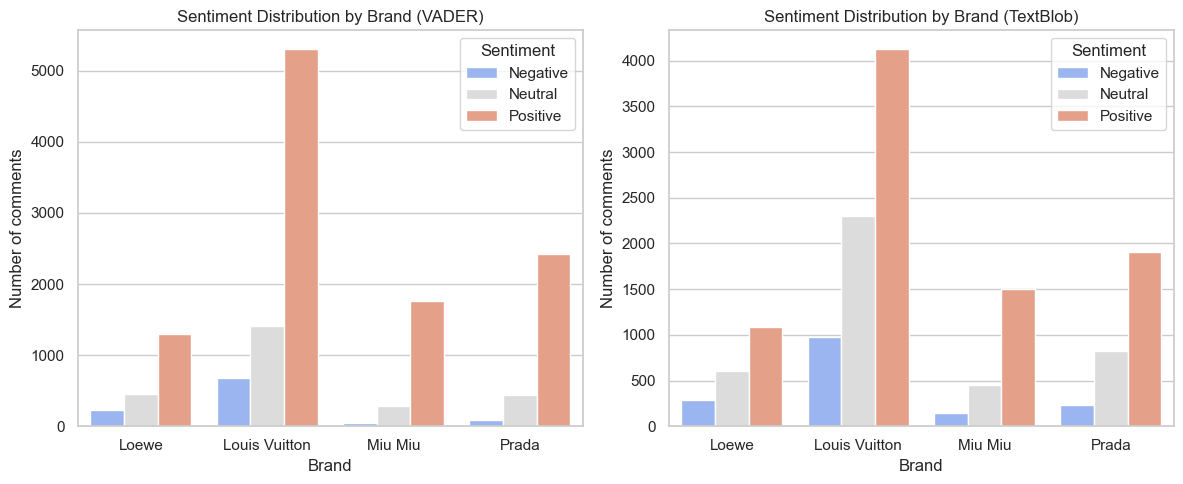

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"

plt.subplot(1, 2, 1)
vader_counts = (
    df_all
    .groupby([BRAND_COL, "Sentiment_VADER"])
    .size()
    .reset_index(name="Count")
)

sns.barplot(
    data=vader_counts,
    x=BRAND_COL,
    y="Count",
    hue="Sentiment_VADER",
    palette="coolwarm"
)

plt.title("Sentiment Distribution by Brand (VADER)")
plt.ylabel("Number of comments")
plt.xlabel("Brand")
plt.legend(title="Sentiment")

# --- TextBlob ---
plt.subplot(1, 2, 2)
tb_counts = (
    df_all
    .groupby([BRAND_COL, "Sentiment_TextBlob"])
    .size()
    .reset_index(name="Count")
)

sns.barplot(
    data=tb_counts,
    x=BRAND_COL,
    y="Count",
    hue="Sentiment_TextBlob",
    palette="coolwarm"
)

plt.title("Sentiment Distribution by Brand (TextBlob)")
plt.ylabel("Number of comments")
plt.xlabel("Brand")
plt.legend(title="Sentiment")

plt.tight_layout()
plt.show()

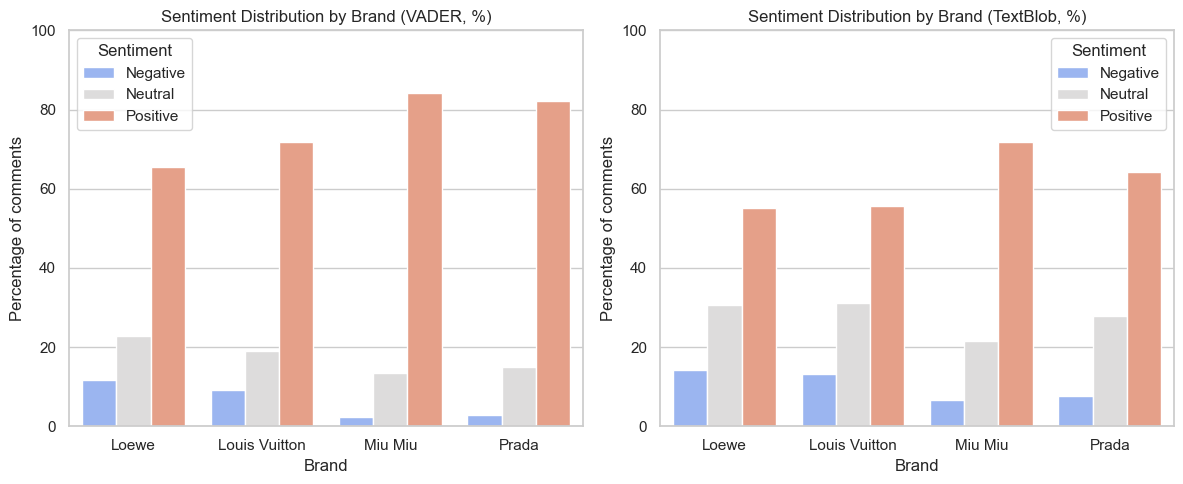

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"


plt.subplot(1, 2, 1)

vader_counts = (
    df_all
    .groupby([BRAND_COL, "Sentiment_VADER"])
    .size()
    .reset_index(name="Count")
)

vader_counts["Percent"] = (
    vader_counts["Count"]
    / vader_counts.groupby(BRAND_COL)["Count"].transform("sum")
    * 100
)

sns.barplot(
    data=vader_counts,
    x=BRAND_COL,
    y="Percent",
    hue="Sentiment_VADER",
    palette="coolwarm"
)

plt.title("Sentiment Distribution by Brand (VADER, %)")
plt.ylabel("Percentage of comments")
plt.xlabel("Brand")
plt.ylim(0, 100)
plt.legend(title="Sentiment")

# --- TextBlob (percentage) ---
plt.subplot(1, 2, 2)

tb_counts = (
    df_all
    .groupby([BRAND_COL, "Sentiment_TextBlob"])
    .size()
    .reset_index(name="Count")
)

tb_counts["Percent"] = (
    tb_counts["Count"]
    / tb_counts.groupby(BRAND_COL)["Count"].transform("sum")
    * 100
)

sns.barplot(
    data=tb_counts,
    x=BRAND_COL,
    y="Percent",
    hue="Sentiment_TextBlob",
    palette="coolwarm"
)

plt.title("Sentiment Distribution by Brand (TextBlob, %)")
plt.ylabel("Percentage of comments")
plt.xlabel("Brand")
plt.ylim(0, 100)
plt.legend(title="Sentiment")

plt.tight_layout()
plt.show()


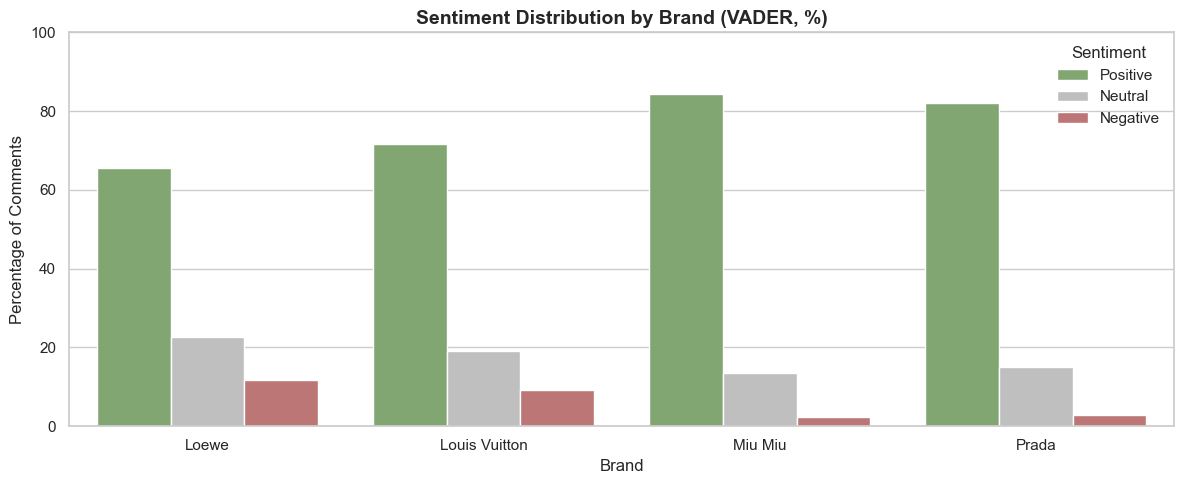

Figure saved at: C:\Users\Pilar\TFM\figures\vader_comparative_sentiment.png


In [6]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 5))

BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"

vader_counts = (
    df_all
    .groupby([BRAND_COL, "Sentiment_VADER"])
    .size()
    .reset_index(name="Count")
)

vader_counts["Percent"] = (
    vader_counts["Count"]
    / vader_counts.groupby(BRAND_COL)["Count"].transform("sum")
    * 100
)

# Order of sentiments
sentiment_order = ["Positive", "Neutral", "Negative"]

# Soft, diffused palette 
palette = {
    "Positive": "#7FAE6A",   # green
    "Neutral":  "#BFBFBF",   # grey
    "Negative": "#C96A6A"    # red
}

sns.barplot(
    data=vader_counts,
    x=BRAND_COL,
    y="Percent",
    hue="Sentiment_VADER",
    hue_order=sentiment_order,
    palette=palette
)

plt.title(
    "Sentiment Distribution by Brand (VADER, %)",
    fontsize=14,
    weight="bold"
)
plt.ylabel("Percentage of Comments")
plt.xlabel("Brand")
plt.ylim(0, 100)
plt.legend(title="Sentiment", frameon=False)

plt.tight_layout()

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

out_path = FIG_DIR / "vader_comparative_sentiment.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()

print(f"Figure saved at: {out_path.resolve()}")


In [7]:
# Map brands to fashion groups
BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"

group_map = {
    "Loewe": "LVMH",
    "Louis Vuitton": "LVMH",
    "Prada": "Prada Group",
    "Miu Miu": "Prada Group"
}

df_all["Fashion_Group"] = df_all[BRAND_COL].map(group_map)

df_all[[BRAND_COL, "Fashion_Group"]].drop_duplicates().sort_values(BRAND_COL)


Brand Fashion_Group
0              Loewe          LVMH
1977   Louis Vuitton          LVMH
9374         Miu Miu   Prada Group
11466          Prada   Prada Group

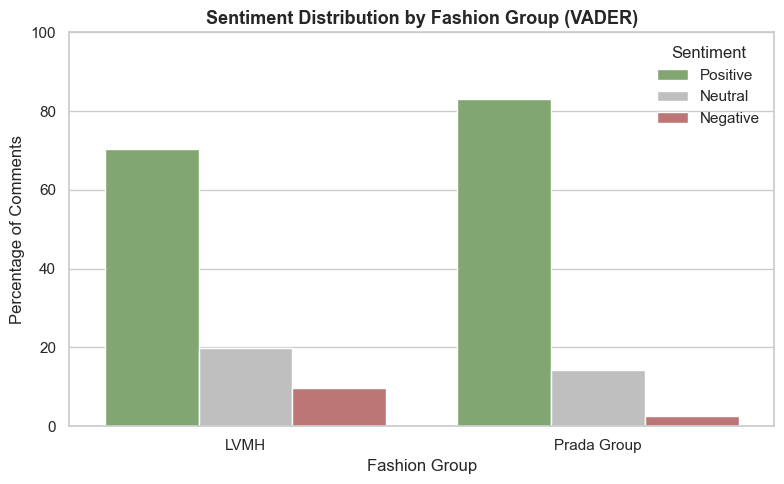

In [8]:
plt.figure(figsize=(8, 5))

group_sentiment = (
    df_all
    .groupby(["Fashion_Group", "Sentiment_VADER"])
    .size()
    .reset_index(name="Count")
)

group_sentiment["Percent"] = (
    group_sentiment["Count"]
    / group_sentiment.groupby("Fashion_Group")["Count"].transform("sum")
    * 100
)

# Order sentiments for consistency
sentiment_order = ["Positive", "Neutral", "Negative"]

# Consistent palette
palette = {
    "Positive": "#7FAE6A",
    "Neutral":  "#BFBFBF",
    "Negative": "#C96A6A"
}

sns.barplot(
    data=group_sentiment,
    x="Fashion_Group",
    y="Percent",
    hue="Sentiment_VADER",
    hue_order=sentiment_order,
    palette=palette
)

plt.title("Sentiment Distribution by Fashion Group (VADER)", fontsize=13, weight="bold")
plt.ylabel("Percentage of Comments")
plt.xlabel("Fashion Group")
plt.ylim(0, 100)
plt.legend(title="Sentiment", frameon=False)

plt.tight_layout()
plt.show()


## Negative Sentiment Analysis 


===== LOEWE =====
Total negative comments: 233
Top words in negative comments:
[('sadness', 166), ('other', 50), ('want', 15), ('collection', 12), ('need', 10), ('price', 10), ('crying', 9), ('love', 9), ('get', 9), ('please', 8)]


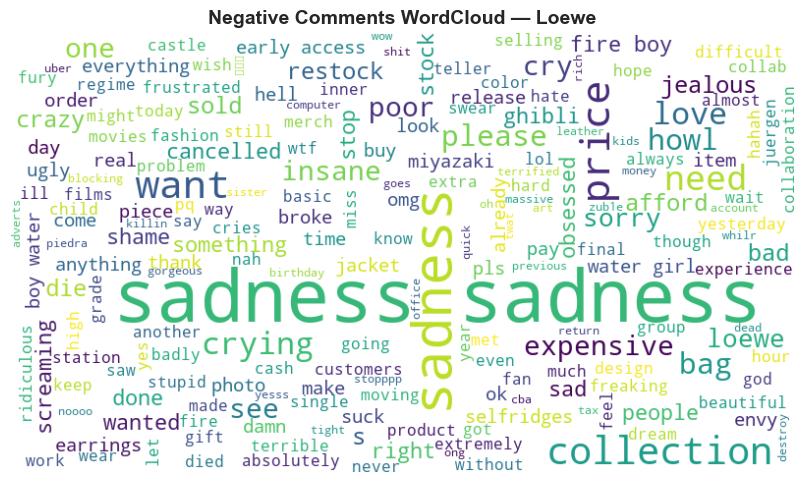

 Saved: C:\Users\Pilar\TFM\figures\wordcloud_negative_loewe.png

===== LOUIS VUITTON =====
Total negative comments: 680
Top words in negative comments:
[('other', 213), ('anger', 195), ('sadness', 185), ('people', 46), ('ugly', 45), ('dots', 37), ('like', 36), ('horrible', 35), ('bad', 32), ('collection', 31)]


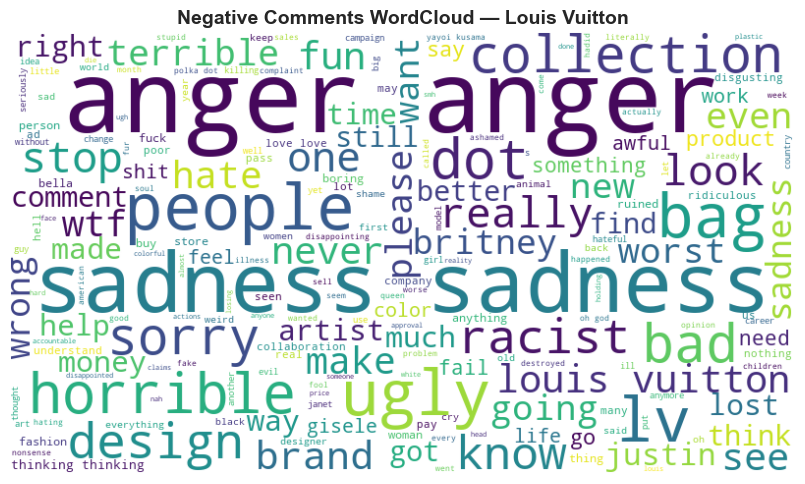

 Saved: C:\Users\Pilar\TFM\figures\wordcloud_negative_louis_vuitton.png

===== MIU MIU =====
Total negative comments: 47
Top words in negative comments:
[('sadness', 50), ('love', 14), ('other', 10), ('excitement', 7), ('miu', 4), ('high', 4), ('cannot', 3), ('ugly', 3), ('shoes', 3), ('want', 3)]


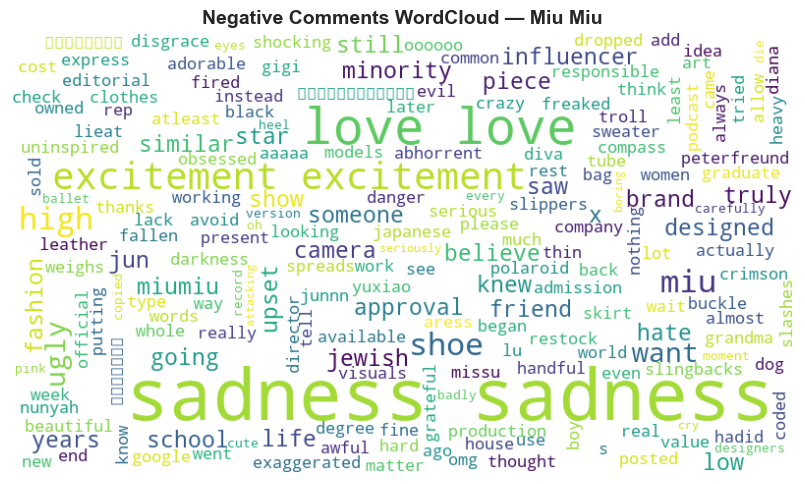

 Saved: C:\Users\Pilar\TFM\figures\wordcloud_negative_miu_miu.png

===== PRADA =====
Total negative comments: 85
Top words in negative comments:
[('sadness', 70), ('strange', 13), ('prada', 9), ('shoes', 9), ('anger', 8), ('doctor', 5), ('angel', 5), ('massive', 5), ('attack', 5), ('like', 5)]


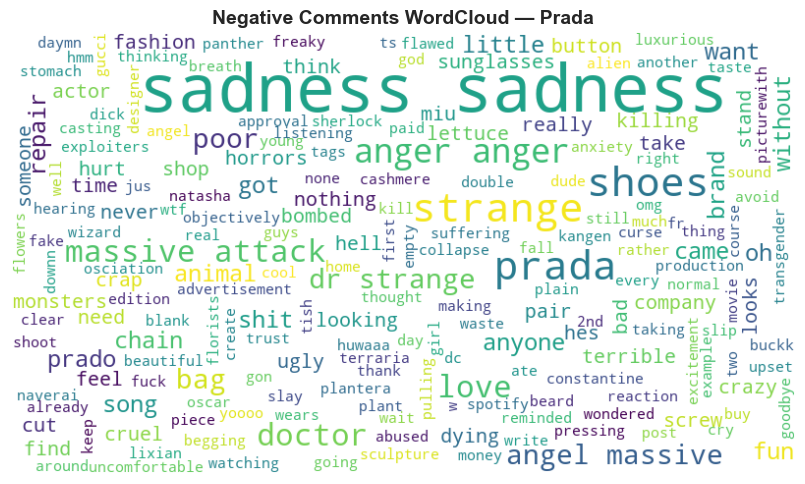

 Saved: C:\Users\Pilar\TFM\figures\wordcloud_negative_prada.png


In [9]:
BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"
TEXT_COL = "comment_clean" if "comment_clean" in df_all.columns else "Processed_Comment"

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

def top_words(series, top_n=10):
    all_text = " ".join(series.astype(str))
    words = [w for w in all_text.split() if len(w) >= 3]  
    return Counter(words).most_common(top_n)

# Unique brands
brands = df_all[BRAND_COL].dropna().unique()

for brand in brands:
    print(f"\n===== {str(brand).upper()} =====")

    df_brand = df_all[df_all[BRAND_COL] == brand].copy()

    # Only negative comments (VADER)
    negative_comments = (
        df_brand[df_brand["Sentiment_VADER"] == "Negative"][TEXT_COL]
        .dropna()
        .astype(str)
    )

    print(f"Total negative comments: {len(negative_comments)}")

    print("Top words in negative comments:")
    print(top_words(negative_comments, top_n=10))

    # WordCloud for negative comments
    if len(negative_comments) > 0:
        text = " ".join(negative_comments.tolist())

        wc_neg = WordCloud(
            width=800,
            height=450,
            background_color="white"
        ).generate(text)

        plt.figure(figsize=(9, 5))
        plt.imshow(wc_neg, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Negative Comments WordCloud — {brand}", fontsize=14, weight="bold")
        plt.tight_layout()

        out_path = FIG_DIR / f"wordcloud_negative_{str(brand).lower().replace(' ','_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
        plt.show()

        print(f" Saved: {out_path.resolve()}")

In [10]:
BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"
TEXT_COL = "comment_clean" if "comment_clean" in df_all.columns else "Processed_Comment"

# Filter only negative comments according to TextBlob
df_neg = df_all[df_all["Sentiment_TextBlob"] == "Negative"].copy()

# Function to extract top words
def top_words(series, top_n=10):
    all_text = " ".join(series.astype(str))
    words = [w for w in all_text.split() if len(w) >= 3]  # simple noise filter
    return Counter(words).most_common(top_n)

# Iterate by brand
brands = df_neg[BRAND_COL].dropna().unique()

for brand in brands:
    df_brand = df_neg[df_neg[BRAND_COL] == brand].copy()

    # --- Top negative words ---
    top_neg_words = top_words(df_brand[TEXT_COL], top_n=10)
    df_words = (
        pd.DataFrame(top_neg_words, columns=["Word", "Count"])
        .sort_values("Count", ascending=False)
        .reset_index(drop=True)
    )

    display(
        df_words.style
        .background_gradient(subset=["Count"], cmap="Reds")
        .set_caption(f"Top Negative Words — {brand}")
    )

   
    df_brand["Polarity"] = df_brand[TEXT_COL].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity
    )

    most_negative = df_brand.nsmallest(
        5, "Polarity"
    )[[TEXT_COL, "Polarity"]]

    display(
        most_negative.style
        .background_gradient(subset=["Polarity"], cmap="coolwarm")
        .set_caption(f"Most Negative Comments — {brand}")
    )


## Positive Sentiment Analysis 


===== LOEWE =====
Total positive comments: 1294
Top words in positive comments:
[('love', 1935), ('excitement', 403), ('other', 292), ('approval', 162), ('want', 50), ('sadness', 49), ('fun', 44), ('like', 43), ('bag', 37), ('cute', 35)]


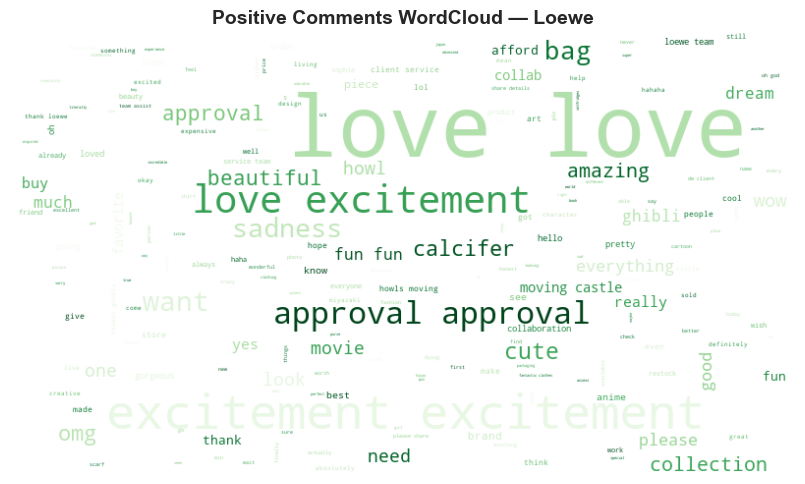

✅ Saved: C:\Users\Pilar\TFM\figures\wordcloud_positive_loewe.png

===== LOUIS VUITTON =====
Total positive comments: 5303
Top words in positive comments:
[('love', 7955), ('excitement', 2558), ('approval', 1715), ('other', 1153), ('fun', 589), ('like', 265), ('beautiful', 218), ('one', 94), ('wow', 87), ('bag', 85)]


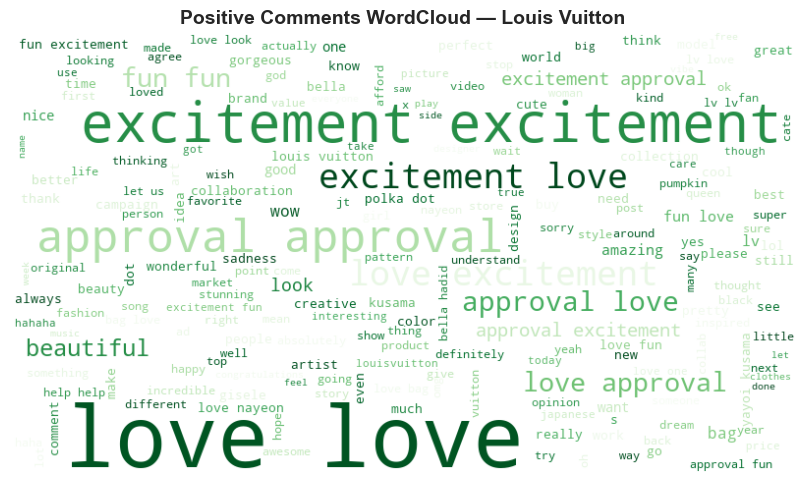

✅ Saved: C:\Users\Pilar\TFM\figures\wordcloud_positive_louis_vuitton.png

===== MIU MIU =====
Total positive comments: 1762
Top words in positive comments:
[('love', 3203), ('excitement', 715), ('approval', 288), ('other', 211), ('jun', 72), ('miu', 71), ('fun', 57), ('beautiful', 56), ('miumiu', 32), ('like', 22)]


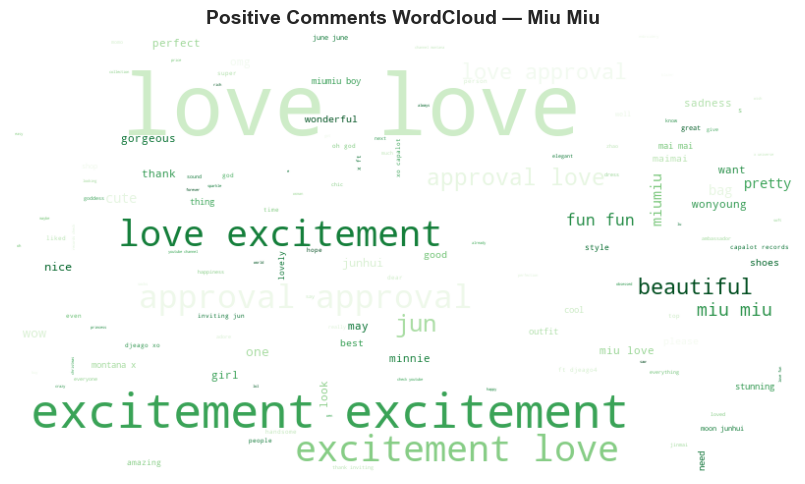

✅ Saved: C:\Users\Pilar\TFM\figures\wordcloud_positive_miu_miu.png

===== PRADA =====
Total positive comments: 2429
Top words in positive comments:
[('love', 3327), ('excitement', 1091), ('approval', 721), ('other', 389), ('prada', 87), ('beautiful', 83), ('xian', 76), ('fun', 62), ('lixian', 38), ('good', 36)]


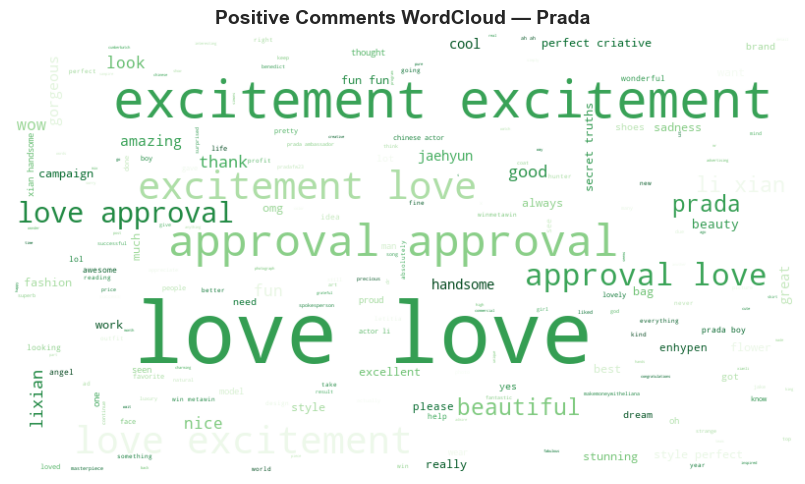

✅ Saved: C:\Users\Pilar\TFM\figures\wordcloud_positive_prada.png


In [11]:
BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"
TEXT_COL = "comment_clean" if "comment_clean" in df_all.columns else "Processed_Comment"

# Output folder
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

def top_words(series, top_n=10):
    all_text = " ".join(series.astype(str))
    words = [w for w in all_text.split() if len(w) >= 3]  # simple noise filter
    return Counter(words).most_common(top_n)

# Unique brands
brands = df_all[BRAND_COL].dropna().unique()

for brand in brands:
    print(f"\n===== {str(brand).upper()} =====")

    df_brand = df_all[df_all[BRAND_COL] == brand].copy()

    # Only positive comments (VADER)
    positive_comments = (
        df_brand[df_brand["Sentiment_VADER"] == "Positive"][TEXT_COL]
        .dropna()
        .astype(str)
    )

    print(f"Total positive comments: {len(positive_comments)}")

    print("Top words in positive comments:")
    print(top_words(positive_comments, top_n=10))

    # WordCloud for positive comments
    if len(positive_comments) > 0:
        text = " ".join(positive_comments.tolist())

        wc_pos = WordCloud(
            width=800,
            height=450,
            background_color="white",
            colormap="Greens"
        ).generate(text)

        plt.figure(figsize=(9, 5))
        plt.imshow(wc_pos, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Positive Comments WordCloud — {brand}", fontsize=14, weight="bold")
        plt.tight_layout()

        out_path = FIG_DIR / f"wordcloud_positive_{str(brand).lower().replace(' ','_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
        plt.show()

        print(f"✅ Saved: {out_path.resolve()}")


In [12]:
BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"
TEXT_COL = "comment_clean" if "comment_clean" in df_all.columns else "Processed_Comment"

# Filter ONLY positive comments according to TextBlob
df_pos = df_all[df_all["Sentiment_TextBlob"] == "Positive"].copy()

# Function to get top words
def top_words(series, top_n=10):
    all_text = " ".join(series.astype(str))
    words = [w for w in all_text.split() if len(w) >= 3]  # simple noise filter
    return Counter(words).most_common(top_n)

# Iterate by brand
brands = df_pos[BRAND_COL].dropna().unique()

for brand in brands:
    df_brand = df_pos[df_pos[BRAND_COL] == brand].copy()

    # Top positive words
    top_pos_words = top_words(df_brand[TEXT_COL], top_n=10)
    df_words = (
        pd.DataFrame(top_pos_words, columns=["Word", "Count"])
        .sort_values("Count", ascending=False)
        .reset_index(drop=True)
    )

    display(
        df_words.style
        .background_gradient(subset=["Count"], cmap="Greens")
        .set_caption(f"Top Positive Words — {brand}")
    )

    # Most positive comments by TextBlob polarity
    df_brand["Polarity"] = df_brand[TEXT_COL].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity
    )
    most_positive = df_brand.nlargest(5, "Polarity")[[TEXT_COL, "Polarity"]]

    display(
        most_positive.style
        .background_gradient(subset=["Polarity"], cmap="coolwarm")
        .set_caption(f"Most Positive Comments — {brand}")
    )


## Topic Modeling by Brand


Processing brand: Loewe
Topic 0: love, wow, beautiful, beauty, favorite, hahaha, oh, today, great, nice, finally, shoes
Topic 1: approval, omg, cute, need, castle, amazing, movie, moving, calcifer, howls, yes, bags
Topic 2: collection, howl, like, sold, good, look, really, restock, know, going, looks, art
Topic 3: sadness, want, fun, bag, afford, like, expensive, price, dream, anime, oh, ghibli
Topic 4: loewe, buy, team, thank, ghibli, store, order, make, sorry, dm, hello, access
Topic 5: excitement, calcifer, lol, time, beautiful, crying, pretty, die, excited, black, jealous, crazy

Topic distribution (%) — Loewe


C:\Users\Pilar\AppData\Local\Temp\ipykernel_776\2687630064.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Topic", y="Percent", data=display_df, palette="Blues")


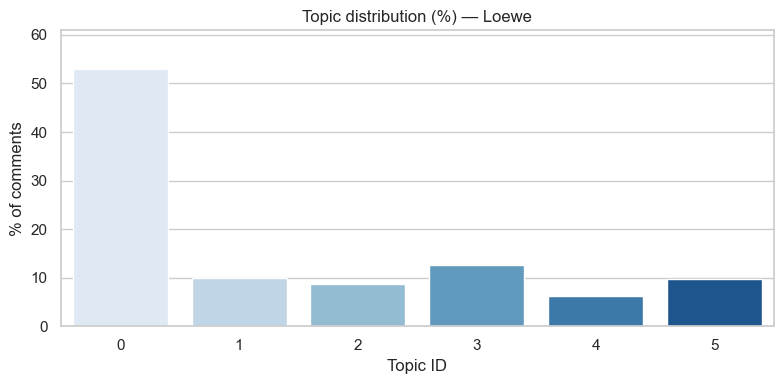


Processing brand: Miu Miu
Topic 0: miu, sadness, beautiful, junhui, need, want, momo, montana, moon, amazing, ft, lu
Topic 1: excitement, perfect, saw, best, new, lovely, love, style, wow, junhui, gorgeous, jun
Topic 2: love, dear, best, super, wow, thanks, jun, great, maimai, girl, beautiful, good
Topic 3: approval, jun, miumiu, wow, girl, boy, oh, thanks, thank, inviting, high, lovely
Topic 4: fun, like, cute, pretty, mai, minnie, maimai, style, stunning, know, outfit, online
Topic 5: bag, omg, wonyoung, nice, shoes, june, gorgeous, wonderful, good, cool, things, liked

Topic distribution (%) — Miu Miu


C:\Users\Pilar\AppData\Local\Temp\ipykernel_776\2687630064.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Topic", y="Percent", data=display_df, palette="Blues")


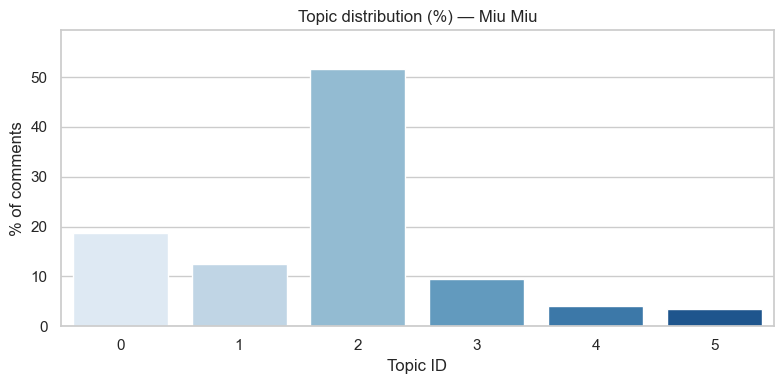


Processing brand: Prada
Topic 0: beautiful, fun, lixian, looks, prada, perfect, stunning, fashion, brand, campaign, flower, thought
Topic 1: prada, xian, li, like, jaehyun, gorgeous, thank, cool, strange, bag, actor, thanks
Topic 2: excitement, sadness, handsome, omg, enhypen, life, gazaunderattack, creative, letitia, best, lovely, people
Topic 3: approval, style, beauty, perfect, prada, criative, pretty, let, wife, excellent, best, awesome
Topic 4: good, nice, wow, amazing, shoes, angel, got, secret, man, great, really, truths
Topic 5: love, awesome, favorite, black, wonderful, lovely, letitia, omg, best, handsome, perfect, gorgeous

Topic distribution (%) — Prada


C:\Users\Pilar\AppData\Local\Temp\ipykernel_776\2687630064.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Topic", y="Percent", data=display_df, palette="Blues")


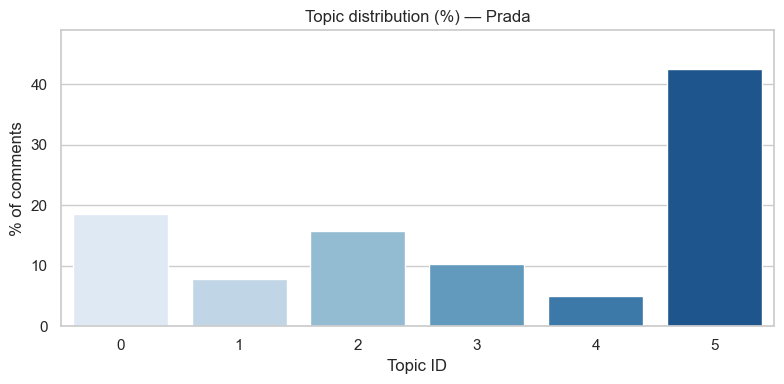


Processing brand: Louis Vuitton
Topic 0: sadness, lv, collection, like, bag, really, want, help, ugly, great, gisele, design
Topic 1: love, approval, nayeon, amazing, wonderful, nissy, christy, loved, divine, aaaaaaah, baaaby, ah
Topic 2: fun, like, looks, thinking, gorgeous, bag, mane, better, black, stunning, sadio, agree
Topic 3: excitement, anger, best, perfect, cool, cate, omg, amazing, dongyu, zhou, awful, purse
Topic 4: beautiful, wow, bella, nice, look, good, like, cute, lol, hadid, queen, oh
Topic 5: dots, louis, vuitton, kusama, art, artist, yayoi, people, model, collaboration, work, polka

Topic distribution (%) — Louis Vuitton


C:\Users\Pilar\AppData\Local\Temp\ipykernel_776\2687630064.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Topic", y="Percent", data=display_df, palette="Blues")


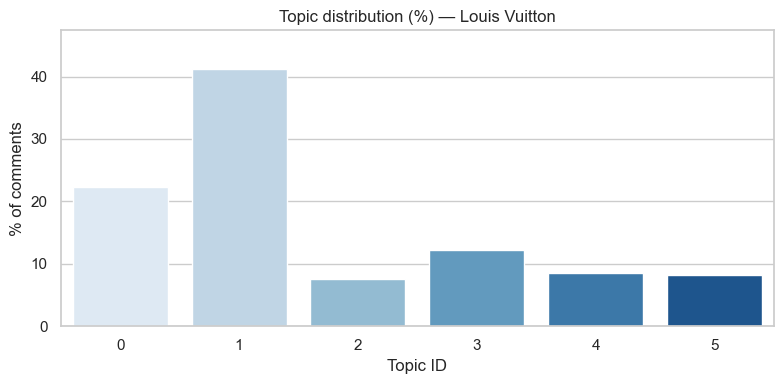


 Results exported to: C:\Users\Pilar\TFM\outputs\TFM_topic_modeling_results.xlsx


In [13]:
sns.set(style="whitegrid")

# -------- Options --------
N_TOPICS = 6
MAX_FEATURES = 2000
TOP_WORDS = 12
RANDOM_STATE = 42

BRAND_COL = "brand" if "brand" in df_all.columns else "Brand"
TEXT_COL  = "comment_clean" if "comment_clean" in df_all.columns else "Processed_Comment"

# Clean non-empty texts
df_all = df_all.copy()
df_all[TEXT_COL] = df_all[TEXT_COL].fillna("").astype(str)
df_all_nonempty = df_all[df_all[TEXT_COL].str.strip() != ""].copy()

# Stable order (important for reproducibility)
if "Nº" in df_all_nonempty.columns:
    df_all_nonempty = df_all_nonempty.sort_values("Nº")
elif "date" in df_all_nonempty.columns:
    df_all_nonempty = df_all_nonempty.sort_values("date")

# Helper: top words per topic
def get_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append((topic_idx, top_words))
    return topics

# Store results per brand
results_by_brand = {}

brands = df_all_nonempty[BRAND_COL].dropna().unique()

for brand in brands:
    print("\n" + "=" * 60)
    print(f"Processing brand: {brand}")
    print("=" * 60)

    df_brand = df_all_nonempty[df_all_nonempty[BRAND_COL] == brand].copy()
    texts = df_brand[TEXT_COL].values

    if len(texts) < 20:
        print(f"⚠️ Not enough documents for '{brand}' (n={len(texts)}). Skipping LDA.")
        continue

    vectorizer = CountVectorizer(
        max_df=0.85,
        min_df=5,
        max_features=MAX_FEATURES,
        token_pattern=r"(?u)\b\w\w+\b",
        stop_words="english"
    )
    dtm = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # LDA
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=12,
        learning_method="batch",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    lda.fit(dtm)

    # Topics
    topics = get_topics(lda, feature_names, TOP_WORDS)
    for t, words in topics:
        print(f"Topic {t}: " + ", ".join(words))

    # Assign dominant topic per doc
    doc_topics = lda.transform(dtm)
    dominant_topic = doc_topics.argmax(axis=1)
    topic_prob = doc_topics.max(axis=1)

    df_brand = df_brand.reset_index(drop=True)
    df_brand["LDA_Topic"] = dominant_topic
    df_brand["LDA_Topic_Prob"] = topic_prob

    # Topic distribution (%)
    topic_counts = df_brand["LDA_Topic"].value_counts(normalize=True).sort_index() * 100
    topic_counts = topic_counts.reindex(range(N_TOPICS), fill_value=0)

    display_df = pd.DataFrame({"Topic": topic_counts.index, "Percent": topic_counts.values})

    print(f"\nTopic distribution (%) — {brand}")
    display(display_df.style.format({"Percent": "{:.1f}%"}).background_gradient(subset=["Percent"], cmap="Blues"))

    plt.figure(figsize=(8, 4))
    sns.barplot(x="Topic", y="Percent", data=display_df, palette="Blues")
    plt.title(f"Topic distribution (%) — {brand}")
    plt.ylabel("% of comments")
    plt.xlabel("Topic ID")
    plt.ylim(0, max(5, display_df["Percent"].max() * 1.15))
    plt.tight_layout()
    plt.show()

    results_by_brand[brand] = {
        "df": df_brand,
        "lda_model": lda,
        "vectorizer": vectorizer,
        "topics": topics,
        "topic_distribution": display_df
    }


all_assigned = pd.concat([results_by_brand[b]["df"] for b in results_by_brand.keys()], ignore_index=True)

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

out_path = OUTPUT_DIR / "TFM_topic_modeling_results.xlsx"
all_assigned.to_excel(out_path, index=False)

print(f"\n Results exported to: {out_path.resolve()}")


In [14]:
# TOPIC LABELS (manual interpretation) 
topic_labels = {

    "Loewe": {
        0: "Aesthetic admiration & love",
        1: "Ghibli fandom & film references",
        2: "Collection interest & availability",
        3: "Desire vs price barrier",
        4: "Purchase & customer service",
        5: "Excitement & hype reactions"
    },

    "Louis Vuitton": {
        0: "Critical reactions & dissatisfaction",
        1: "Celebrity admiration & affection",
        2: "Style praise & light reactions",
        3: "Polarized reactions (hype vs critique)",
        4: "Beauty praise & influencer discourse",
        5: "Kusama collaboration & art discourse"
    },

    "Miu Miu": {
        0: "Fandom requests & emotional appeals",
        1: "Hype & styling enthusiasm",
        2: "Affection & gratitude (dominant)",
        3: "Brand appreciation & thanks",
        4: "Outfit talk & playful reactions",
        5: "Product focus & celebrity mentions"
    },

    "Prada": {
        0: "Campaign aesthetics & Flower concept",
        1: "Celebrity focus (Li Xian)",
        2: "Mixed emotions & off-topic discourse",
        3: "Style approval & praise",
        4: "General positive feedback",
        5: "Strong positive affection (dominant)"
    }
}


In [15]:
if "FIG_DIR" in globals():
    SAVE_DIR = Path(FIG_DIR)
elif (Path.cwd() / "figures").exists():
    SAVE_DIR = Path.cwd() / "figures"
else:
    SAVE_DIR = Path.cwd() / "lda_tables"

SAVE_DIR.mkdir(parents=True, exist_ok=True)

print(" SAVE_DIR set to:", SAVE_DIR.resolve())



 SAVE_DIR set to: C:\Users\Pilar\TFM\figures


In [16]:
def make_topic_table_for_brand(results_by_brand, brand, save_dir=None, top_words_n=10):
    from pathlib import Path
    import matplotlib.pyplot as plt
    from IPython.display import display, Image

    if save_dir is None:
        if (Path.cwd() / "figures").exists():
            save_dir = Path.cwd() / "figures"
        else:
            save_dir = Path.cwd() / "lda_tables"

    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    if brand not in results_by_brand:
        print(f"Brand '{brand}' not found in results_by_brand.")
        return

    default_styles = {
        "Loewe": {"header_bg": "#111111", "row_bg_1": "#F6F6F6", "row_bg_2": "#FFFFFF", "edge": "#222222"},
        "Louis Vuitton": {"header_bg": "#2A2A2A", "row_bg_1": "#F6F6F6", "row_bg_2": "#FFFFFF", "edge": "#222222"},
        "Prada": {"header_bg": "#1F1F1F", "row_bg_1": "#F6F6F6", "row_bg_2": "#FFFFFF", "edge": "#222222"},
        "Miu Miu": {"header_bg": "#242424", "row_bg_1": "#F6F6F6", "row_bg_2": "#FFFFFF", "edge": "#222222"},
    }

    styles_source = globals().get("brand_styles", default_styles)
    style = styles_source.get(brand, styles_source.get("Louis Vuitton", default_styles["Louis Vuitton"]))

    dist_df = results_by_brand[brand]["topic_distribution"].copy()
    topics = results_by_brand[brand]["topics"]

    topic_words_map = {t: ", ".join(words[:top_words_n]) for t, words in topics}
    topic_name_map = globals().get("topic_labels", {}).get(brand, {})

    table_df = dist_df.copy()
    table_df["% of comments"] = table_df["Percent"].round(1)
    table_df["Proposed Topic Name"] = table_df["Topic"].map(topic_name_map).fillna("")
    table_df["Top words"] = table_df["Topic"].map(topic_words_map).fillna("")

    table_df = table_df.rename(columns={"Topic": "Topic ID"})
    table_df = table_df[["Topic ID", "Proposed Topic Name", "% of comments", "Top words"]]

    n_rows = len(table_df) + 1
    fig_h = 0.45 * n_rows
    fig, ax = plt.subplots(figsize=(14, fig_h))
    ax.axis("off")

    tbl = ax.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        cellLoc="left",
        colLoc="left",
        loc="center",
        bbox=[0, 0, 1, 0.88]
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9.5)

    for (row, col), cell in tbl.get_celld().items():
        cell.set_edgecolor(style["edge"])
        cell.set_linewidth(0.8)
        cell.PAD = 0.02

        if row == 0:
            cell.set_facecolor(style["header_bg"])
            cell.get_text().set_color("white")
            cell.get_text().set_weight("bold")
            cell.set_height(0.18)
        else:
            cell.set_facecolor(style["row_bg_1"] if row % 2 == 1 else style["row_bg_2"])
            cell.get_text().set_color("#1A1A1A")
            cell.set_height(0.16)

    for r in range(0, len(table_df) + 1):
        tbl[(r, 0)].set_width(0.08)
        tbl[(r, 1)].set_width(0.28)
        tbl[(r, 2)].set_width(0.12)
        tbl[(r, 3)].set_width(0.52)

    fig.subplots_adjust(top=0.90)
    fig.suptitle(f"LDA Topic Summary — {brand}", fontsize=14, weight="bold", y=0.98)

    out_path = save_dir / f"lda_topics_table_{str(brand).lower().replace(' ','_')}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.close(fig)

    display(Image(filename=str(out_path)))
    print(f"Saved and displayed: {out_path.resolve()}")

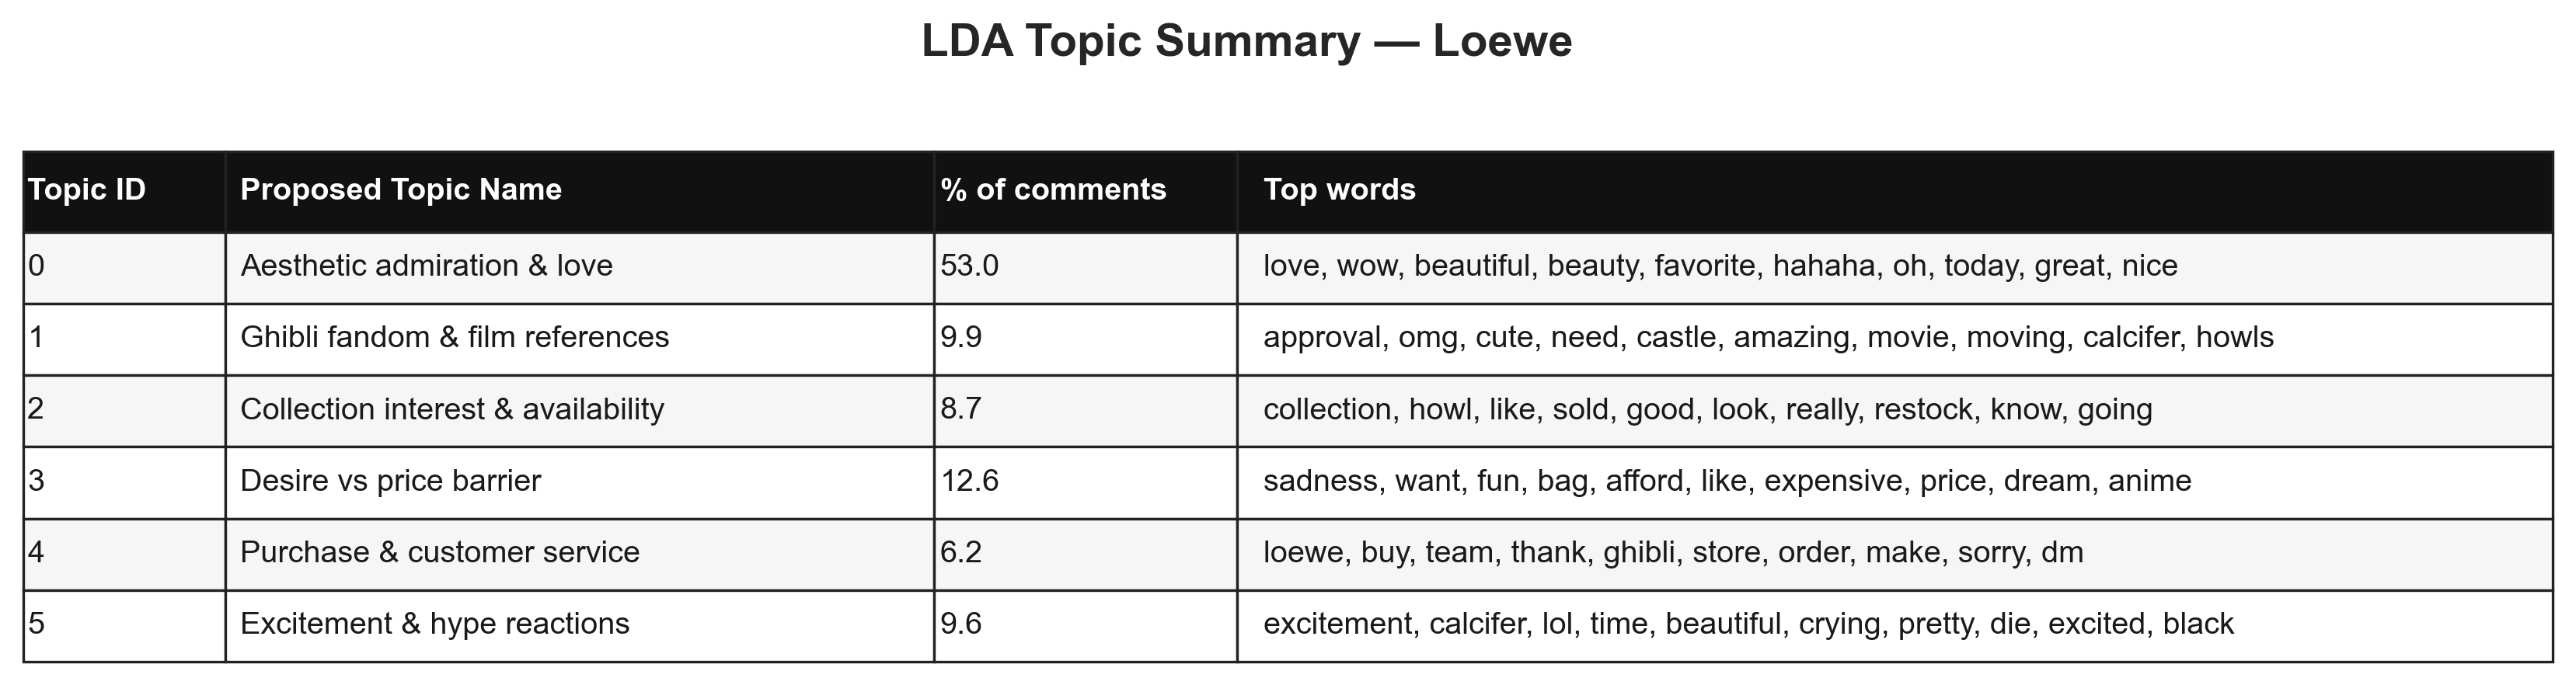

Saved and displayed: C:\Users\Pilar\TFM\figures\lda_topics_table_loewe.png


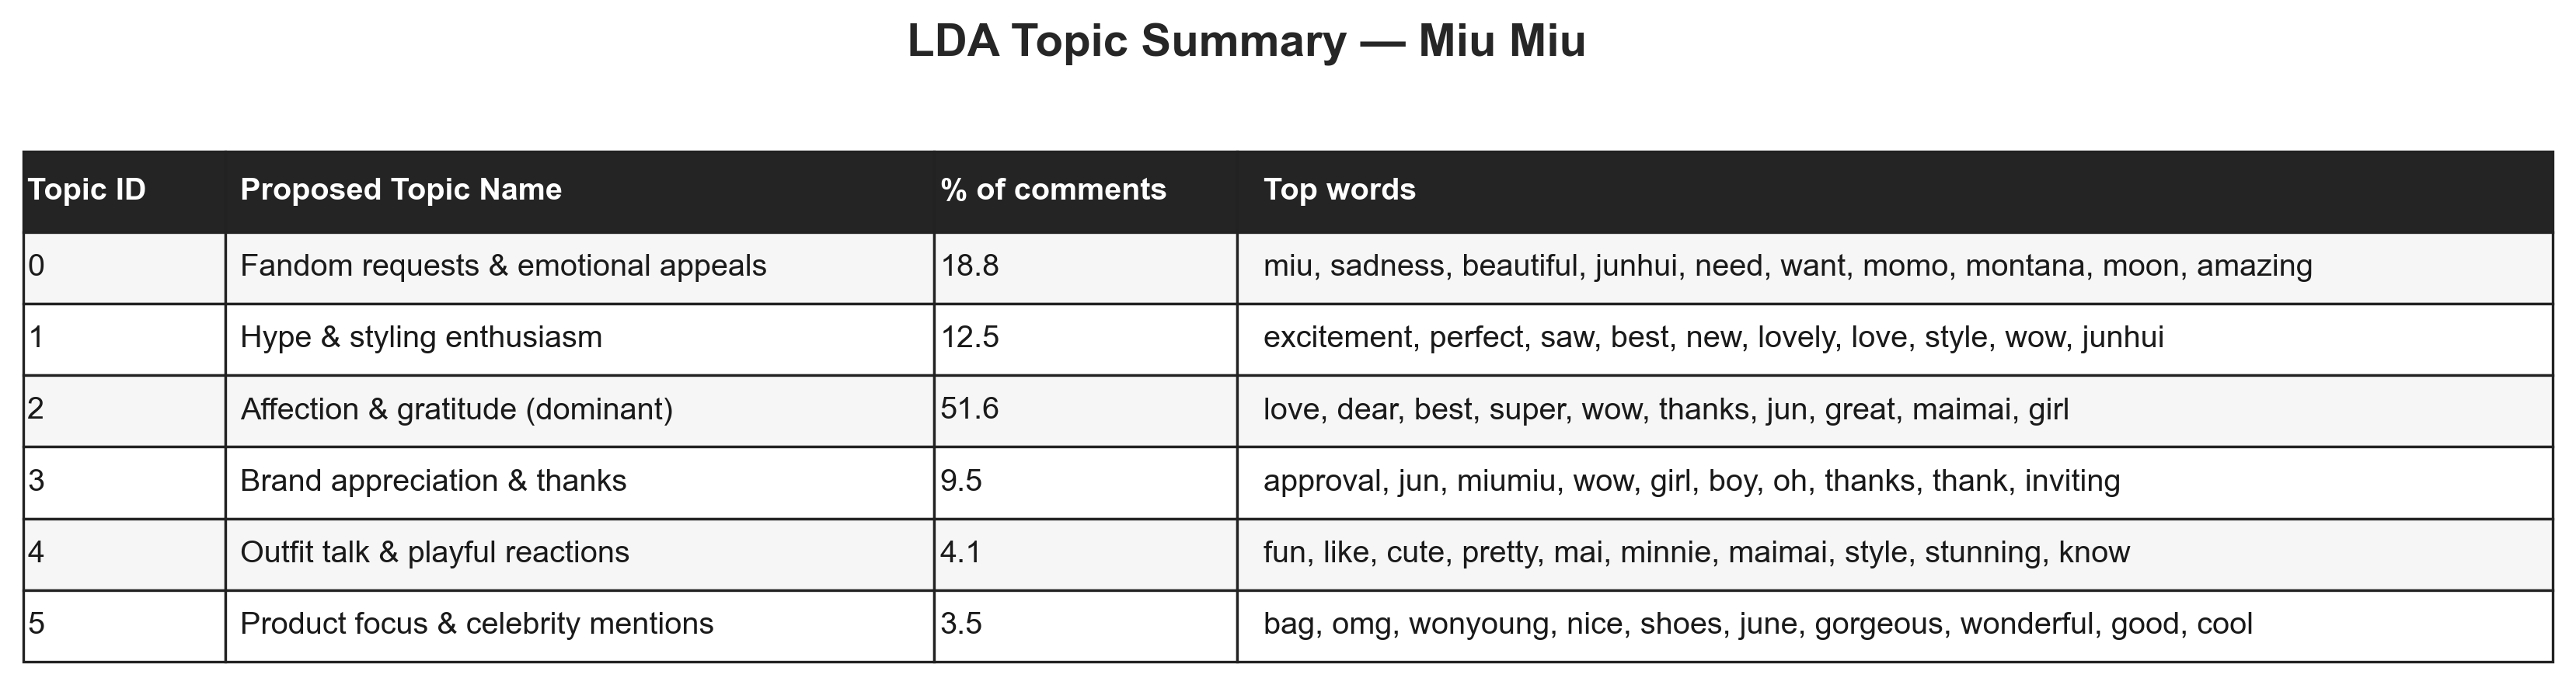

Saved and displayed: C:\Users\Pilar\TFM\figures\lda_topics_table_miu_miu.png


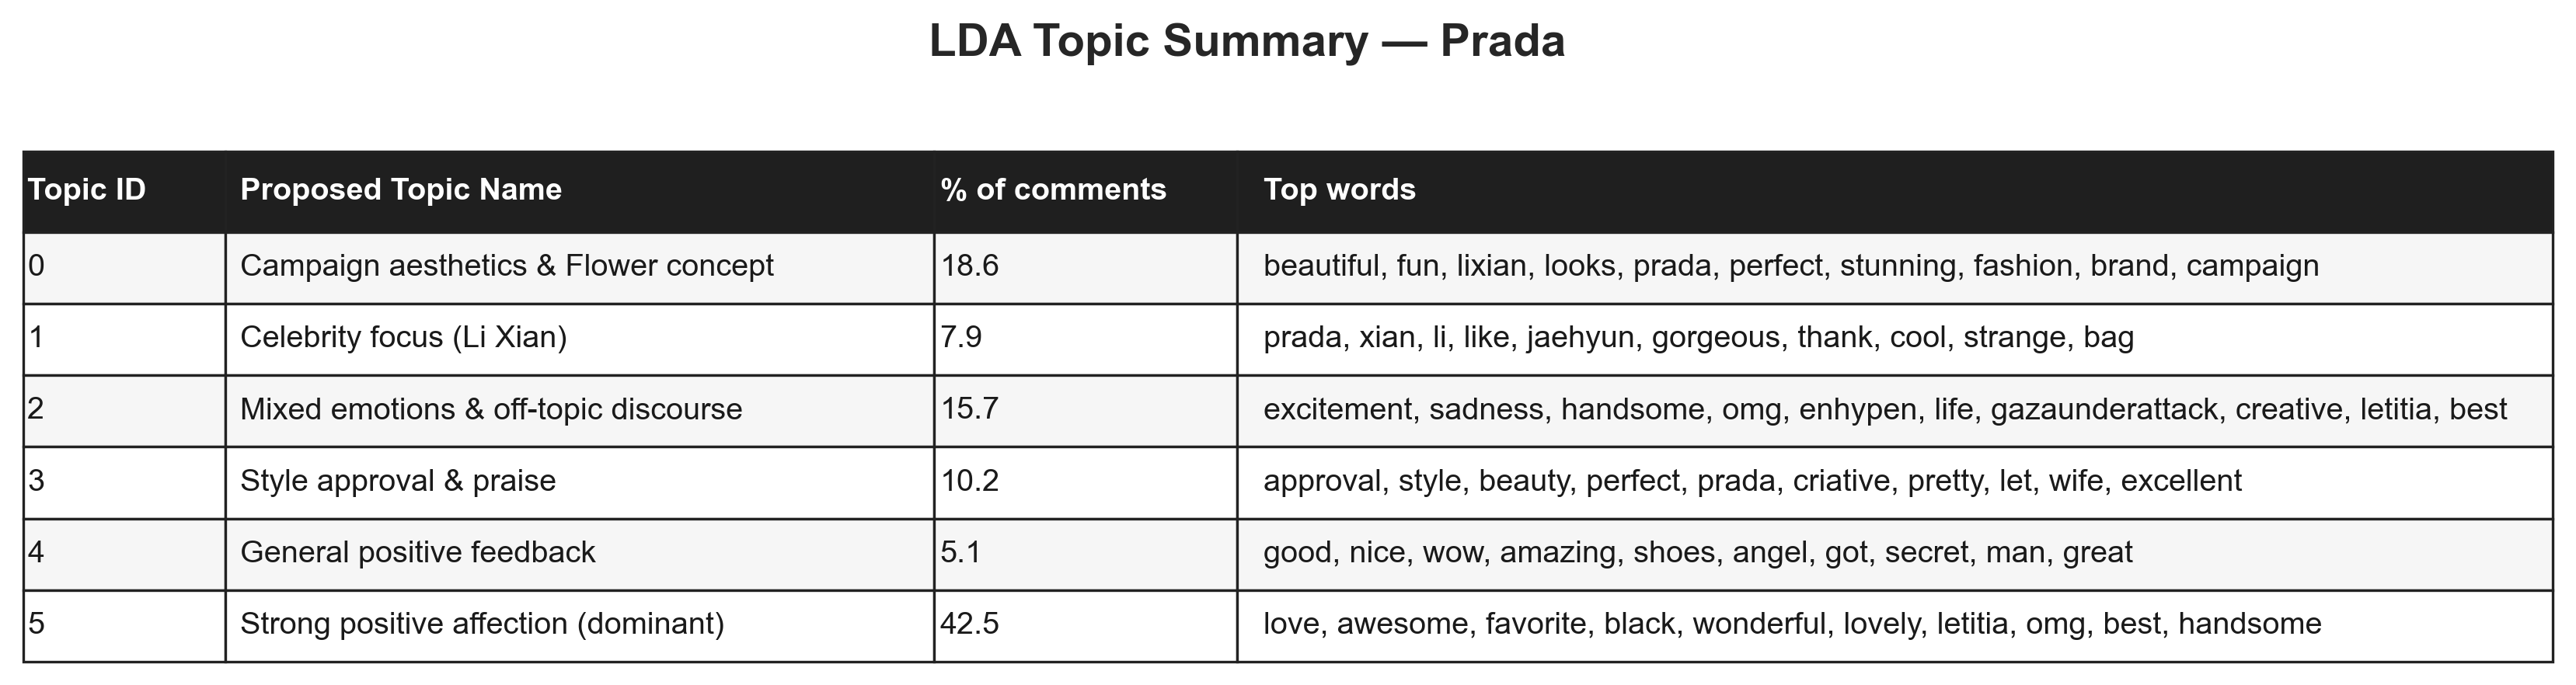

Saved and displayed: C:\Users\Pilar\TFM\figures\lda_topics_table_prada.png


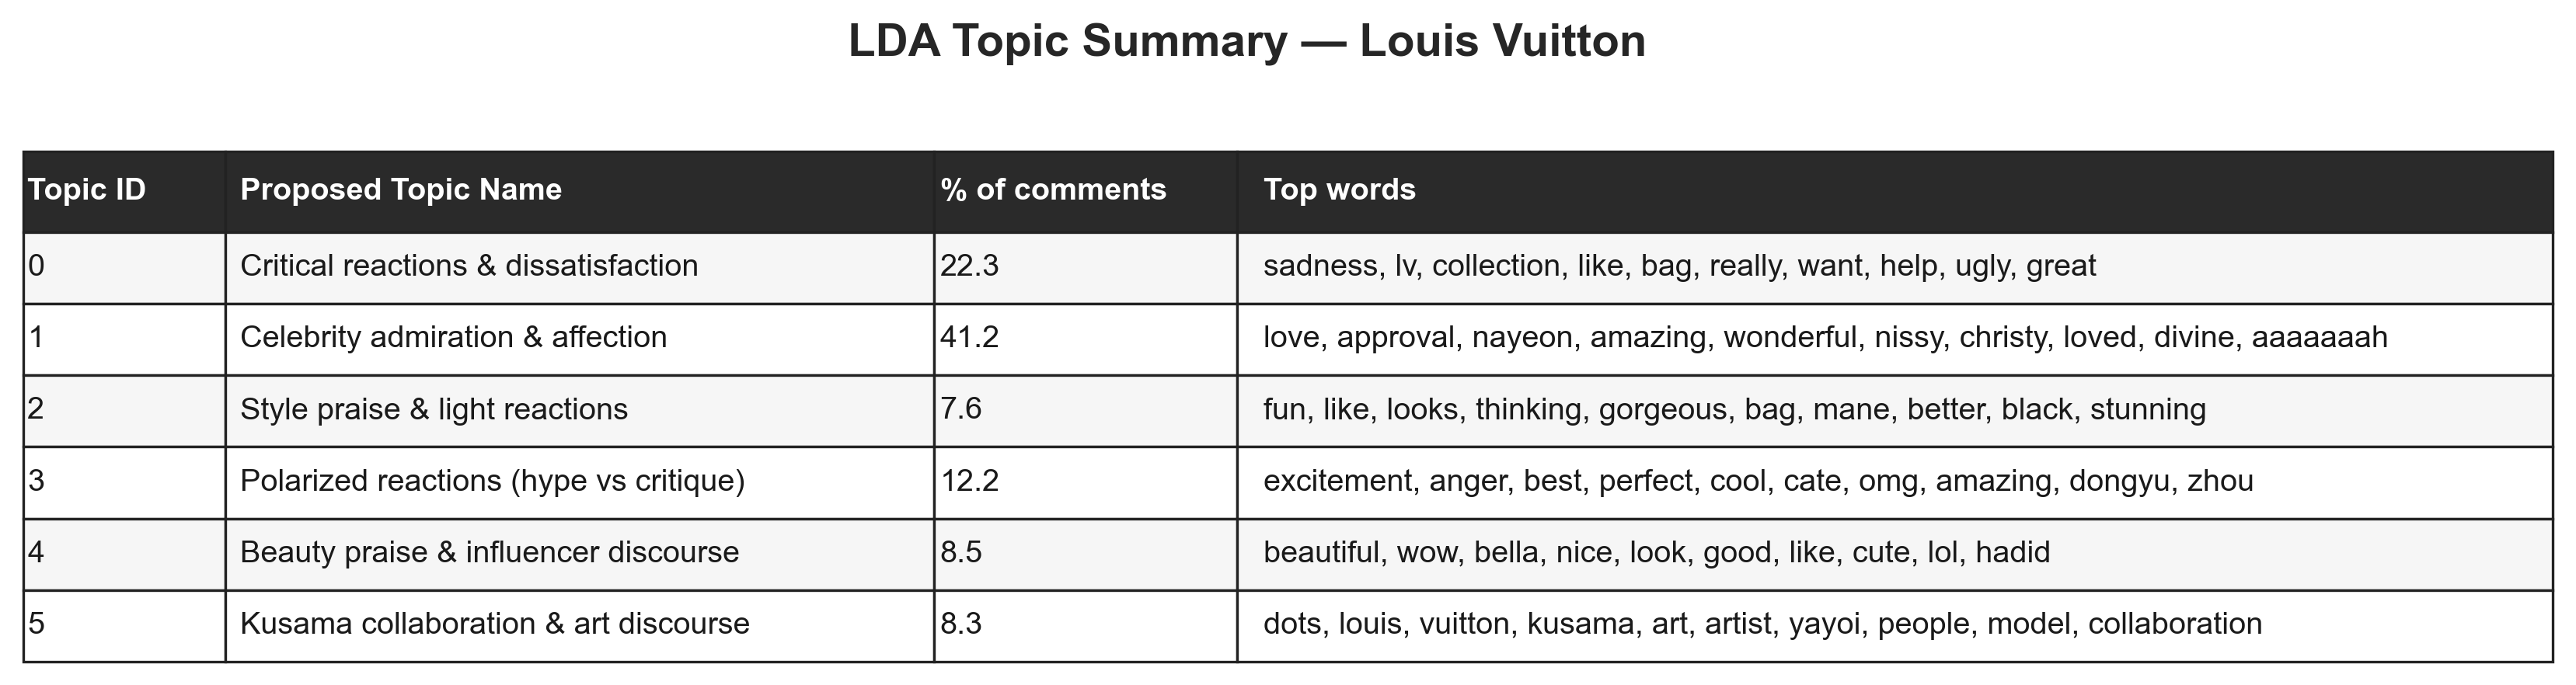

Saved and displayed: C:\Users\Pilar\TFM\figures\lda_topics_table_louis_vuitton.png


In [17]:
for b in results_by_brand.keys():
    make_topic_table_for_brand(results_by_brand, b)


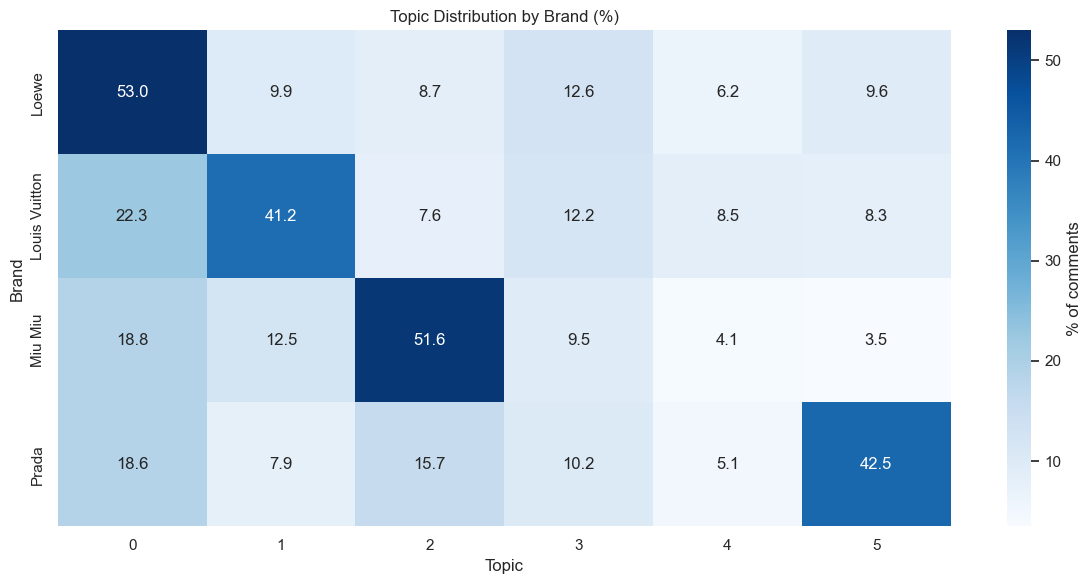

In [18]:
df_topics = all_assigned.copy()

BRAND_COL = "brand" if "brand" in df_topics.columns else "Brand"

topic_counts = (
    df_topics
    .groupby([BRAND_COL, "LDA_Topic"])
    .size()
    .reset_index(name="Count")
)

topic_counts["Percent"] = (
    topic_counts["Count"]
    / topic_counts.groupby(BRAND_COL)["Count"].transform("sum")
    * 100
)

topic_pivot = (
    topic_counts
    .pivot(index=BRAND_COL, columns="LDA_Topic", values="Percent")
    .fillna(0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(topic_pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"label": "% of comments"})
plt.title("Topic Distribution by Brand (%)")
plt.ylabel("Brand")
plt.xlabel("Topic")
plt.tight_layout()
plt.show()


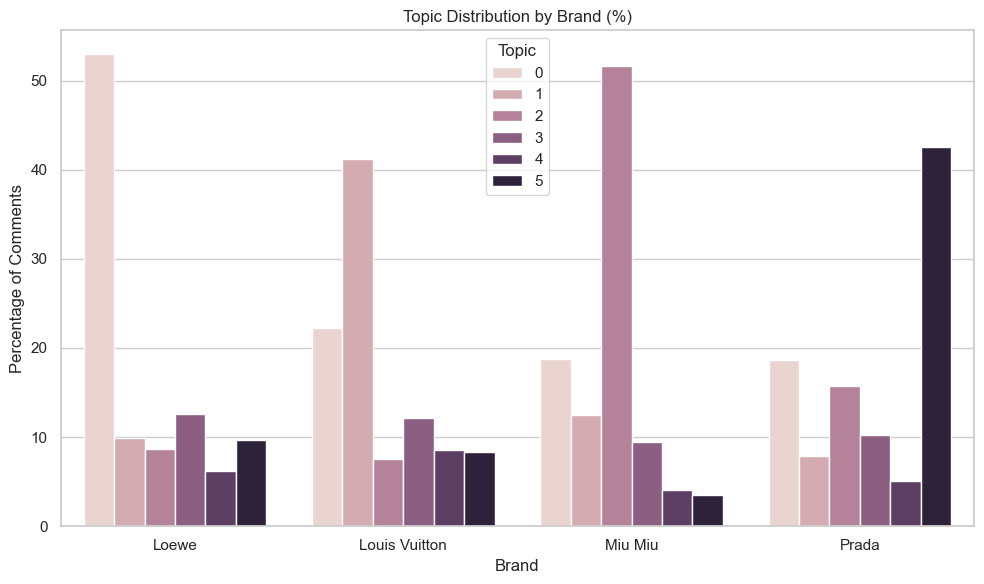

In [19]:
BRAND_COL = "brand" if "brand" in all_assigned.columns else "Brand"

topic_brand = (
    all_assigned
    .groupby([BRAND_COL, "LDA_Topic"])
    .size()
    .reset_index(name="Count")
)

topic_brand["Percent"] = (
    topic_brand["Count"]
    / topic_brand.groupby(BRAND_COL)["Count"].transform("sum")
    * 100
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=topic_brand,
    x=BRAND_COL,
    y="Percent",
    hue="LDA_Topic"
)

plt.title("Topic Distribution by Brand (%)")
plt.ylabel("Percentage of Comments")
plt.xlabel("Brand")
plt.legend(title="Topic")
plt.tight_layout()
plt.show()



WordClouds for brand: Loewe


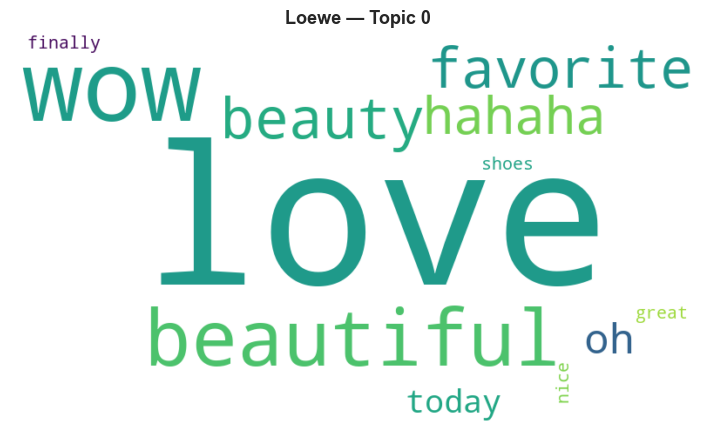

Saved: C:\Users\Pilar\TFM\figures\wordcloud_loewe_topic_0.png


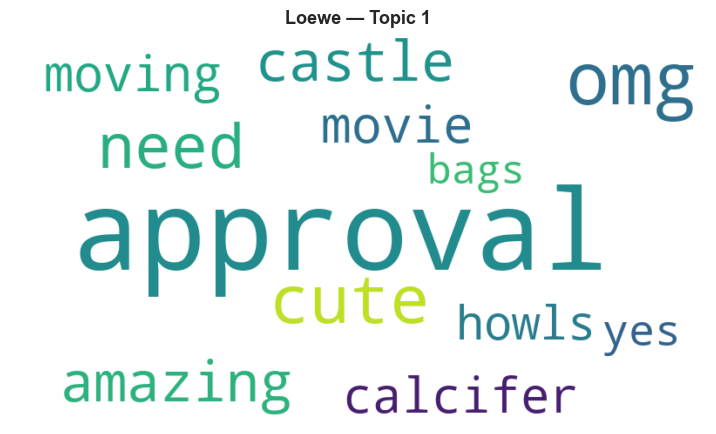

Saved: C:\Users\Pilar\TFM\figures\wordcloud_loewe_topic_1.png


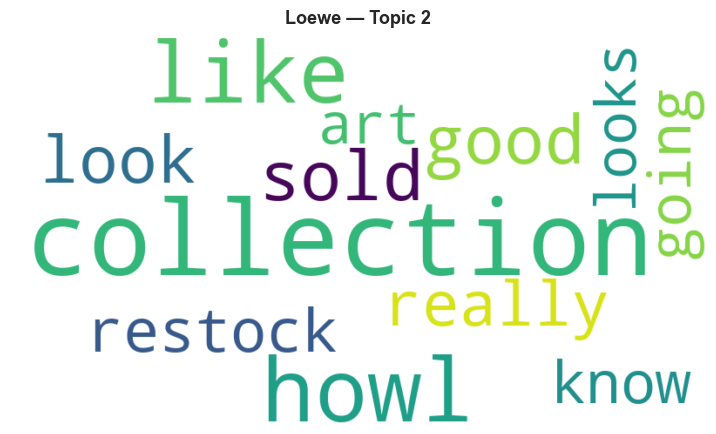

Saved: C:\Users\Pilar\TFM\figures\wordcloud_loewe_topic_2.png


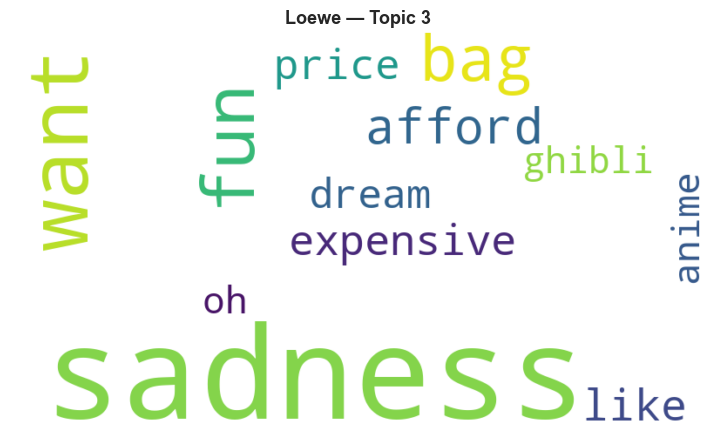

Saved: C:\Users\Pilar\TFM\figures\wordcloud_loewe_topic_3.png


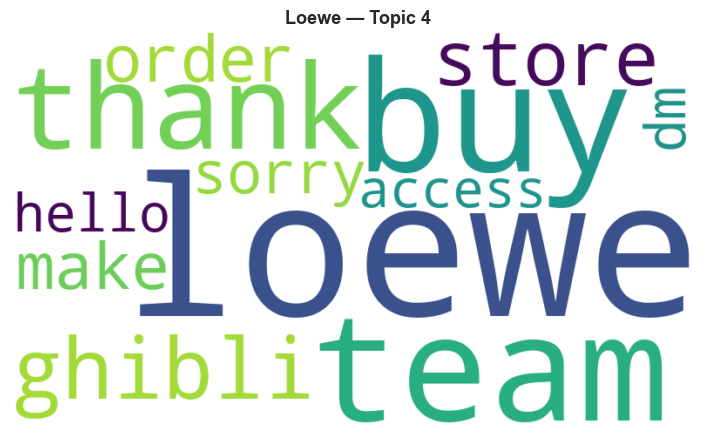

Saved: C:\Users\Pilar\TFM\figures\wordcloud_loewe_topic_4.png


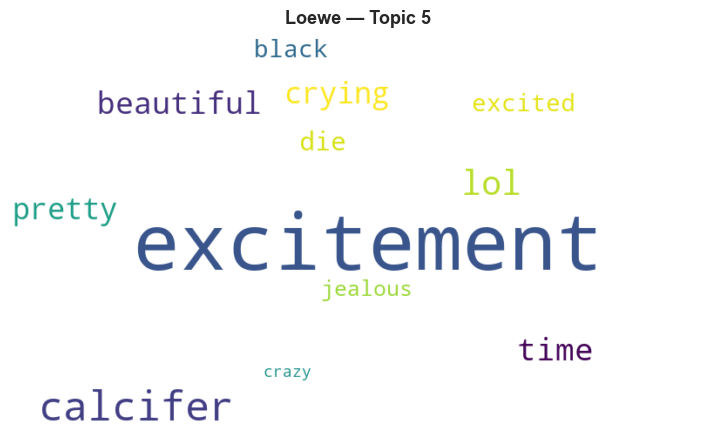

Saved: C:\Users\Pilar\TFM\figures\wordcloud_loewe_topic_5.png

WordClouds for brand: Miu Miu


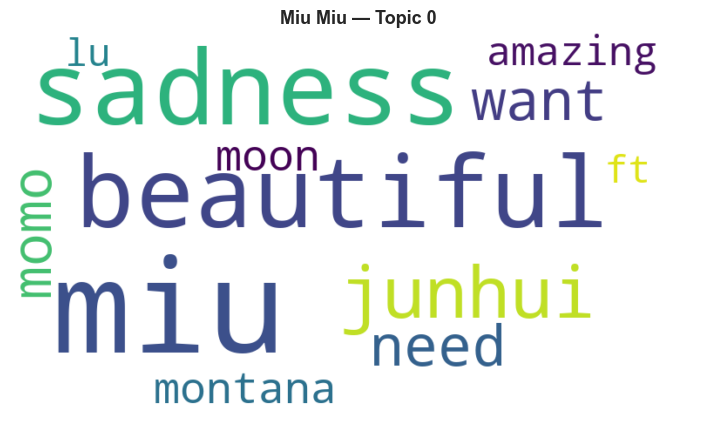

Saved: C:\Users\Pilar\TFM\figures\wordcloud_miu_miu_topic_0.png


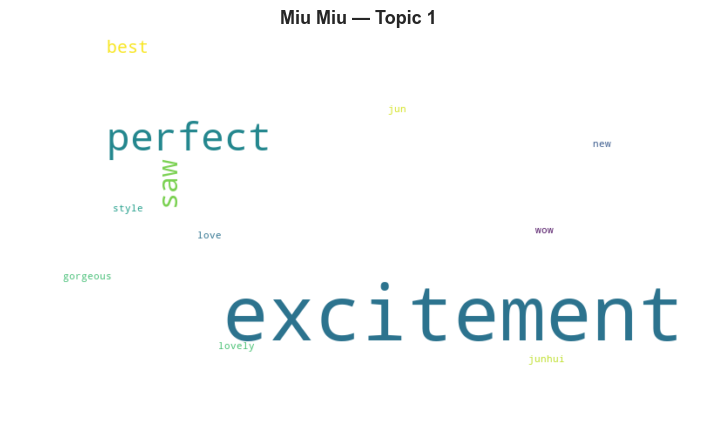

Saved: C:\Users\Pilar\TFM\figures\wordcloud_miu_miu_topic_1.png


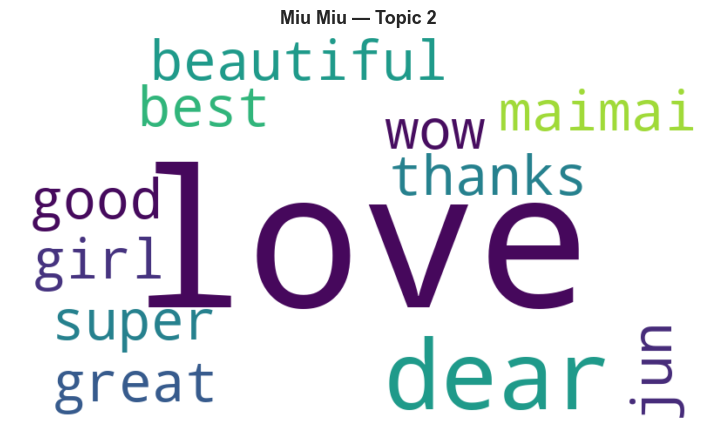

Saved: C:\Users\Pilar\TFM\figures\wordcloud_miu_miu_topic_2.png


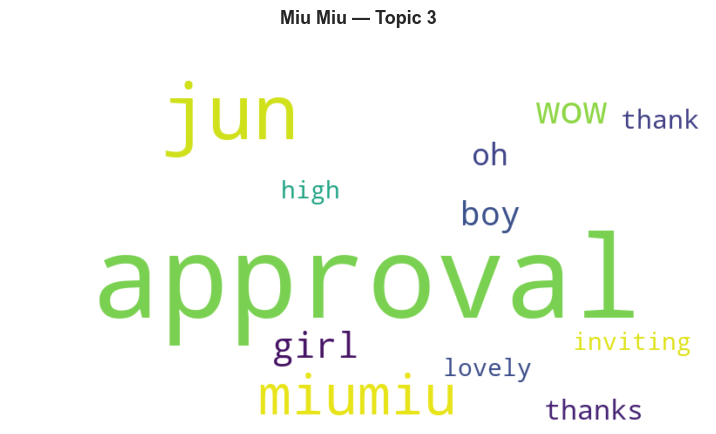

Saved: C:\Users\Pilar\TFM\figures\wordcloud_miu_miu_topic_3.png


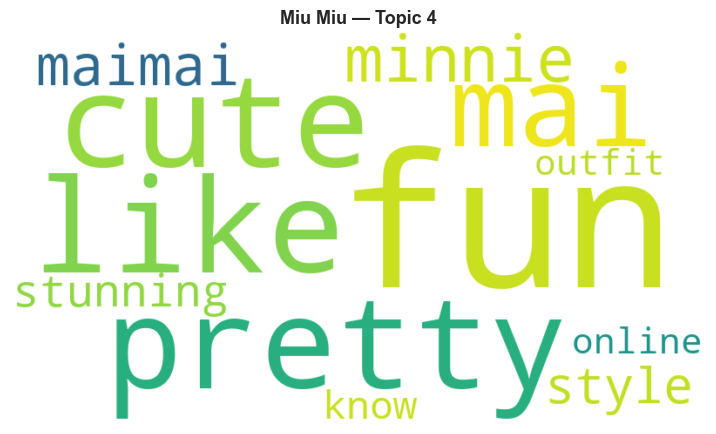

Saved: C:\Users\Pilar\TFM\figures\wordcloud_miu_miu_topic_4.png


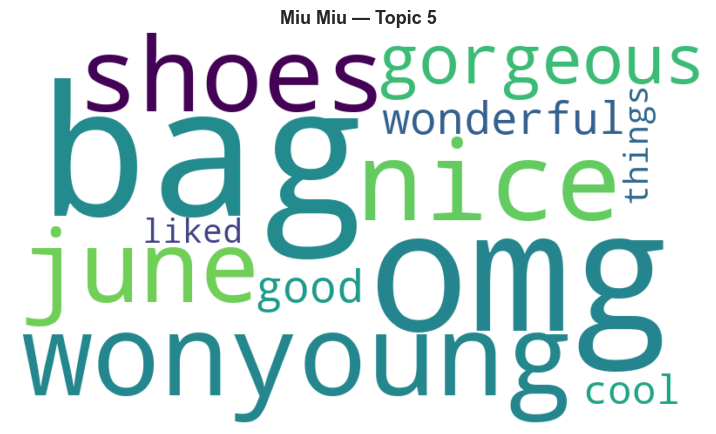

Saved: C:\Users\Pilar\TFM\figures\wordcloud_miu_miu_topic_5.png

WordClouds for brand: Prada


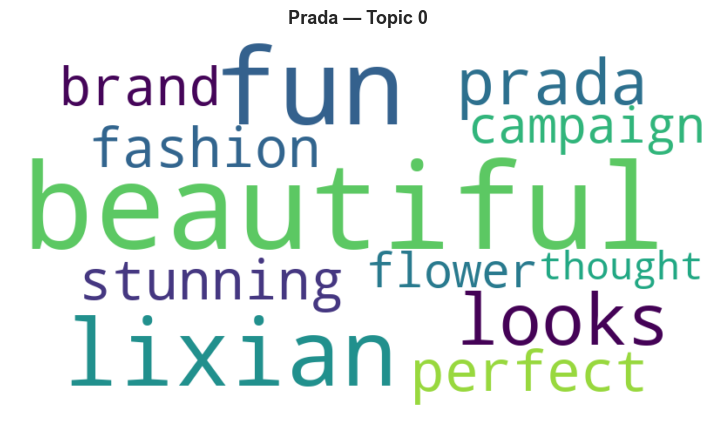

Saved: C:\Users\Pilar\TFM\figures\wordcloud_prada_topic_0.png


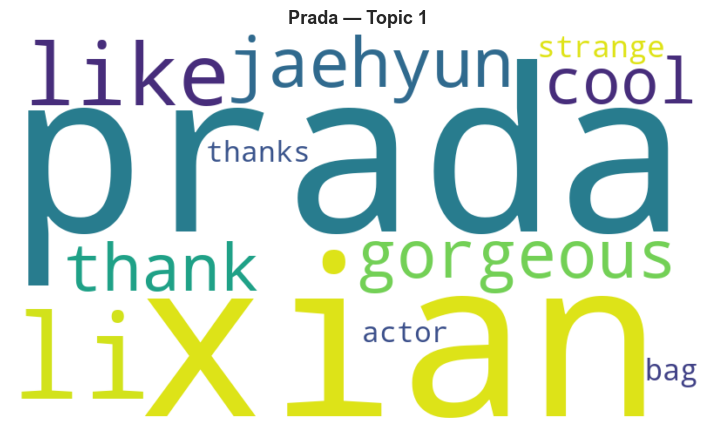

Saved: C:\Users\Pilar\TFM\figures\wordcloud_prada_topic_1.png


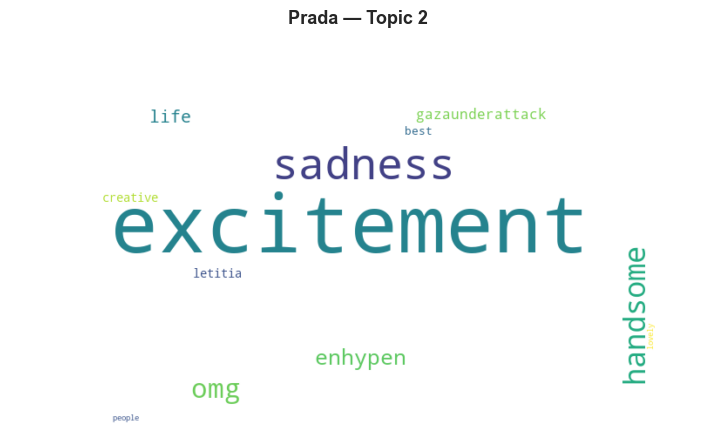

Saved: C:\Users\Pilar\TFM\figures\wordcloud_prada_topic_2.png


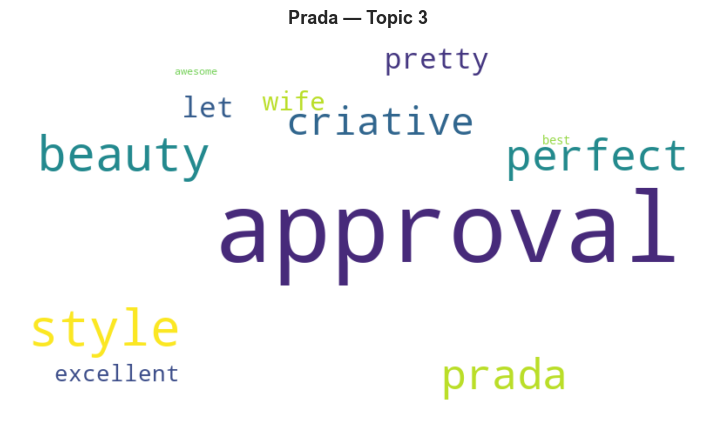

Saved: C:\Users\Pilar\TFM\figures\wordcloud_prada_topic_3.png


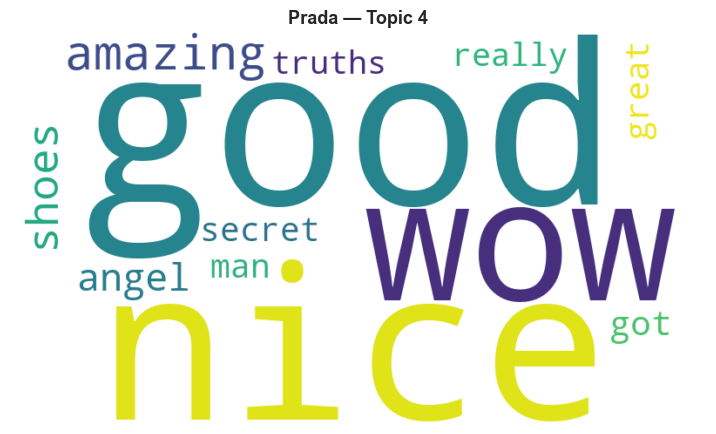

Saved: C:\Users\Pilar\TFM\figures\wordcloud_prada_topic_4.png


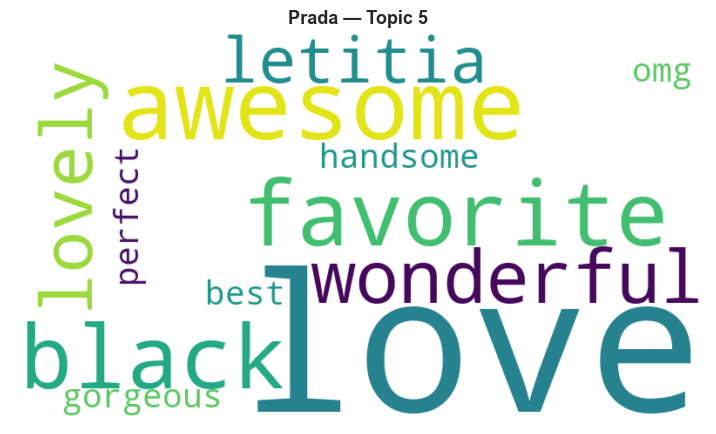

Saved: C:\Users\Pilar\TFM\figures\wordcloud_prada_topic_5.png

WordClouds for brand: Louis Vuitton


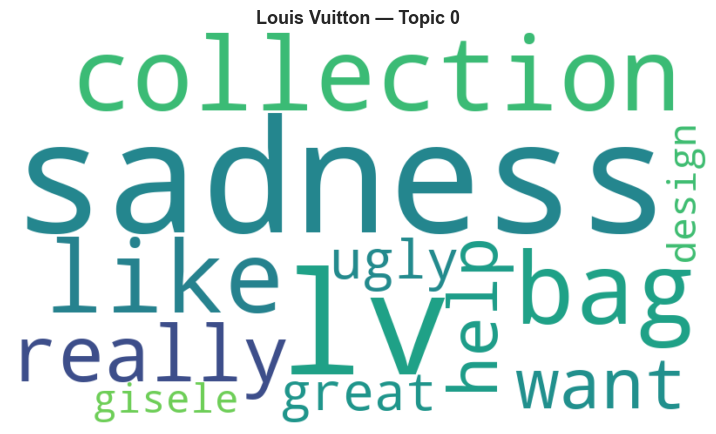

Saved: C:\Users\Pilar\TFM\figures\wordcloud_louis_vuitton_topic_0.png


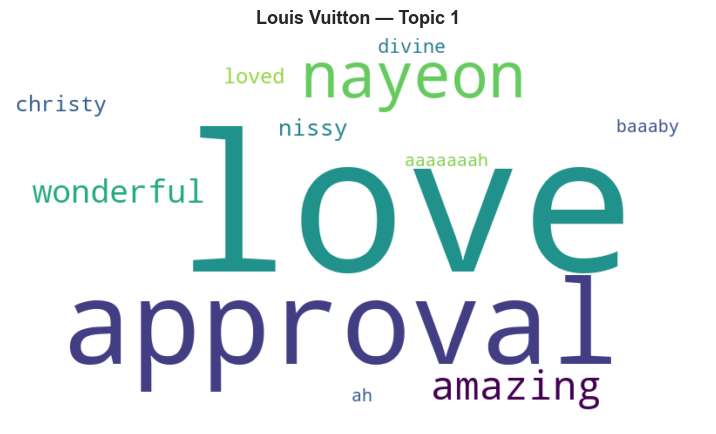

Saved: C:\Users\Pilar\TFM\figures\wordcloud_louis_vuitton_topic_1.png


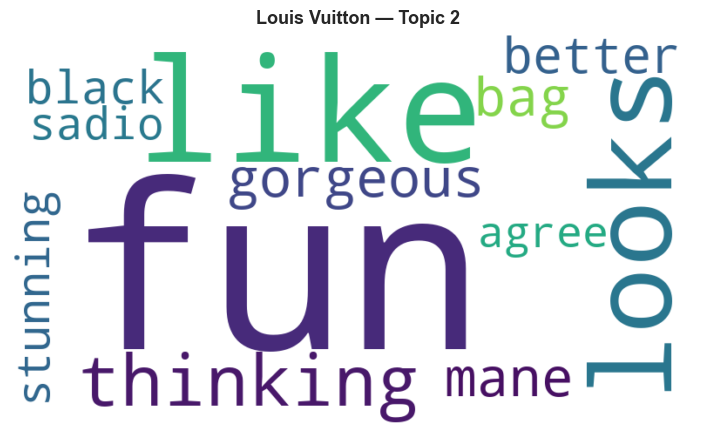

Saved: C:\Users\Pilar\TFM\figures\wordcloud_louis_vuitton_topic_2.png


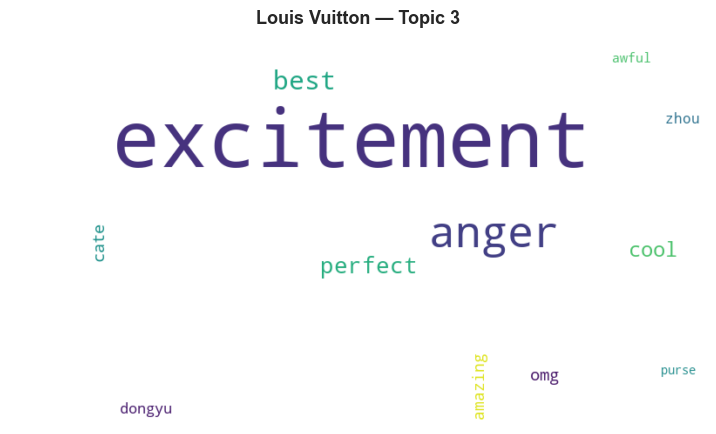

Saved: C:\Users\Pilar\TFM\figures\wordcloud_louis_vuitton_topic_3.png


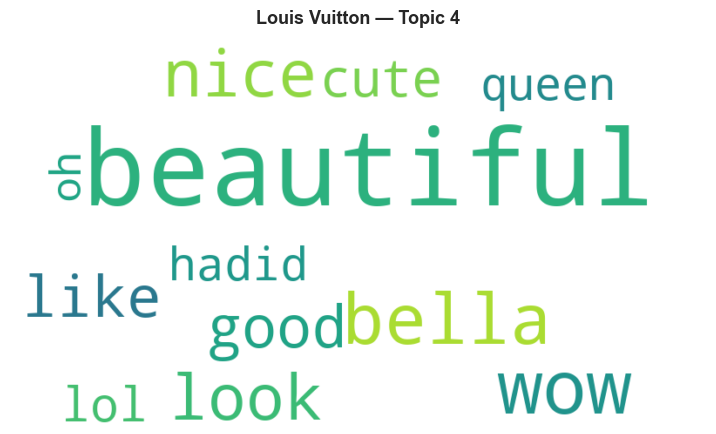

Saved: C:\Users\Pilar\TFM\figures\wordcloud_louis_vuitton_topic_4.png


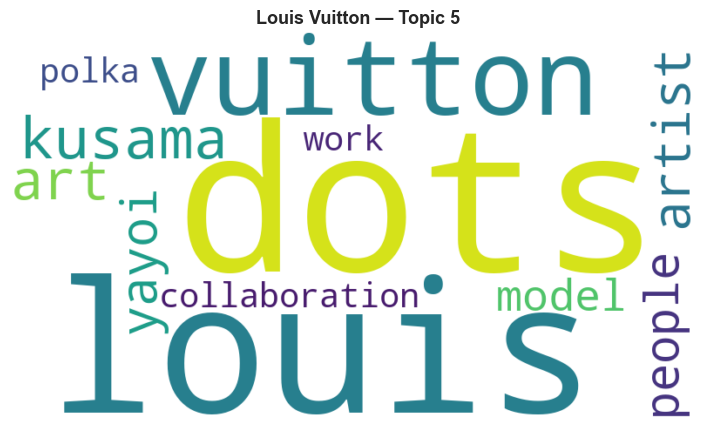

Saved: C:\Users\Pilar\TFM\figures\wordcloud_louis_vuitton_topic_5.png


In [20]:
TOP_WORDS = 12

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

for brand in results_by_brand.keys():
    lda = results_by_brand[brand]["lda_model"]
    vectorizer = results_by_brand[brand]["vectorizer"]
    feature_names = vectorizer.get_feature_names_out()

    print(f"\nWordClouds for brand: {brand}")

    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[:-TOP_WORDS - 1:-1]
        top_words = {feature_names[i]: topic[i] for i in top_indices}

        wc = WordCloud(
            width=800,
            height=450,
            background_color="white"
        ).generate_from_frequencies(top_words)

        plt.figure(figsize=(8, 4.5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{brand} — Topic {topic_idx}", fontsize=13, weight="bold")
        plt.tight_layout()

        out_path = FIG_DIR / f"wordcloud_{brand.lower().replace(' ','_')}_topic_{topic_idx}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
        plt.show()

        print(f"Saved: {out_path.resolve()}")



## Global LDA

In [21]:
N_TOPICS_GLOBAL = 6
MAX_FEATURES = 2000
RANDOM_STATE = 42

TEXT_COL = "comment_clean" if "comment_clean" in df_all.columns else "Processed_Comment"

if "df_all_nonempty" not in globals():
    df_all_nonempty = df_all.copy()
    df_all_nonempty[TEXT_COL] = df_all_nonempty[TEXT_COL].fillna("").astype(str)
    df_all_nonempty = df_all_nonempty[df_all_nonempty[TEXT_COL].str.strip() != ""].copy()
else:
    df_all_nonempty = df_all_nonempty.copy()
    df_all_nonempty[TEXT_COL] = df_all_nonempty[TEXT_COL].fillna("").astype(str)
    df_all_nonempty = df_all_nonempty[df_all_nonempty[TEXT_COL].str.strip() != ""].copy()

texts_all = df_all_nonempty[TEXT_COL].values

vectorizer_global = CountVectorizer(
    max_df=0.85,
    min_df=5,
    max_features=MAX_FEATURES,
    token_pattern=r"(?u)\b\w\w+\b",
    stop_words="english"
)

dtm_global = vectorizer_global.fit_transform(texts_all)
feature_names_global = vectorizer_global.get_feature_names_out()

lda_global = LatentDirichletAllocation(
    n_components=N_TOPICS_GLOBAL,
    max_iter=12,
    learning_method="batch",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lda_global.fit(dtm_global)

doc_topics_global = lda_global.transform(dtm_global)
df_all_nonempty["Global_Topic"] = doc_topics_global.argmax(axis=1)
df_all_nonempty["Global_Topic_Prob"] = doc_topics_global.max(axis=1)

df_all_nonempty[[TEXT_COL, "Global_Topic", "Global_Topic_Prob"]].head(5)


Processed_Comment  Global_Topic  \
0                                   screaming tight twat             0   
9374                                         excitement              3   
11466                                          l love ve             0   
1977   bad fact bad understatement egregious please c...             1   
1                                      jealous  sadness              5   

       Global_Topic_Prob  
0               0.166667  
9374            0.583333  
11466           0.583333  
1977            0.895464  
1               0.388957

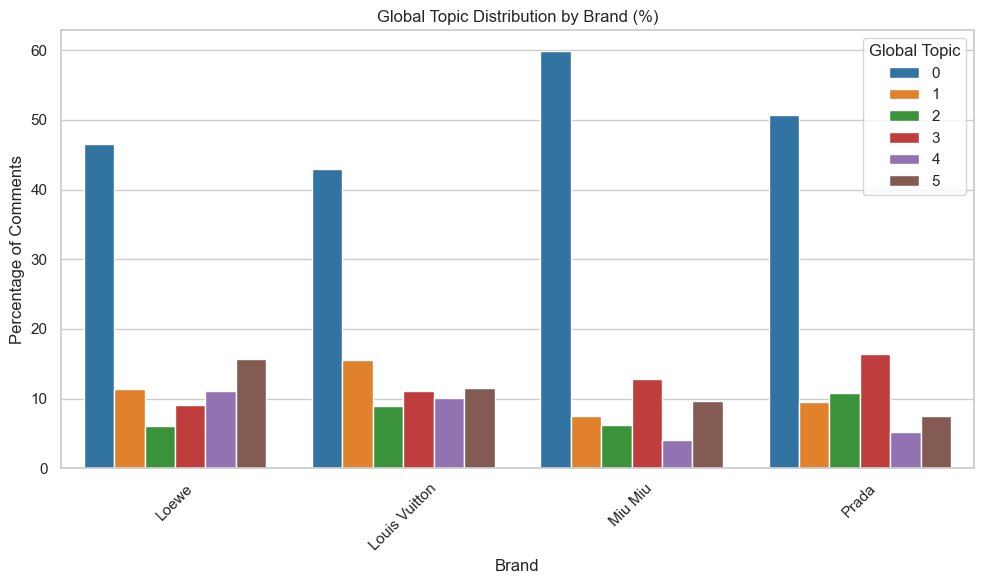

In [22]:
BRAND_COL = "brand" if "brand" in df_all_nonempty.columns else "Brand"

topic_brand_global = (
    df_all_nonempty
    .groupby([BRAND_COL, "Global_Topic"])
    .size()
    .reset_index(name="Count")
)

topic_brand_global["Percent"] = (
    topic_brand_global["Count"]
    / topic_brand_global.groupby(BRAND_COL)["Count"].transform("sum")
    * 100
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=topic_brand_global,
    x=BRAND_COL,
    y="Percent",
    hue="Global_Topic",
    palette="tab10"
)

plt.title("Global Topic Distribution by Brand (%)")
plt.ylabel("Percentage of Comments")
plt.xlabel("Brand")
plt.legend(title="Global Topic")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
BRAND_COL = "brand" if "brand" in topic_brand_global.columns else "Brand"

dominant_topic_per_brand = (
    topic_brand_global
    .groupby(BRAND_COL, as_index=False)
    .apply(lambda x: x.loc[x["Percent"].idxmax(), "Global_Topic"])
    .reset_index(drop=True)
    .rename(columns={"Global_Topic": "Dominant_Global_Topic"})
)

print(dominant_topic_per_brand)

           Brand  None
0          Loewe     0
1  Louis Vuitton     0
2        Miu Miu     0
3          Prada     0


C:\Users\Pilar\AppData\Local\Temp\ipykernel_776\1102306652.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["Percent"].idxmax(), "Global_Topic"])


In [24]:
OP_WORDS = 12  # number of top words per topic

for topic_idx, topic in enumerate(lda_global.components_):
    top_indices = topic.argsort()[:-TOP_WORDS - 1:-1]
    top_words = [feature_names_global[i] for i in top_indices]

    print(f"Global Topic {topic_idx}: {', '.join(top_words)}")

Global Topic 0: love, amazing, mane, lixian, sadio, howls, secret, insane, truths, maimai, yuta, superb
Global Topic 1: fun, anger, like, nayeon, good, really, miu, look, people, xian, li, know
Global Topic 2: approval, wow, omg, need, wear, strange, obsessed, enhypen, prices, amazing, tokyo, spectacular
Global Topic 3: excitement, perfect, gorgeous, prada, style, amazing, lixian, jaehyun, boy, junhui, wait, criative
Global Topic 4: want, collection, lv, nice, louis, vuitton, dots, bella, like, prada, best, pretty
Global Topic 5: sadness, beautiful, like, bag, cute, jun, oh, looks, kusama, help, let, god


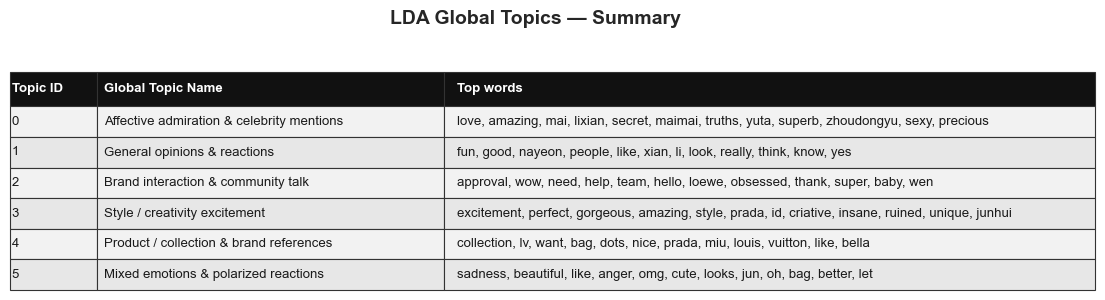

Saved: C:\Users\Pilar\TFM\figures\lda_global_topics_table.png


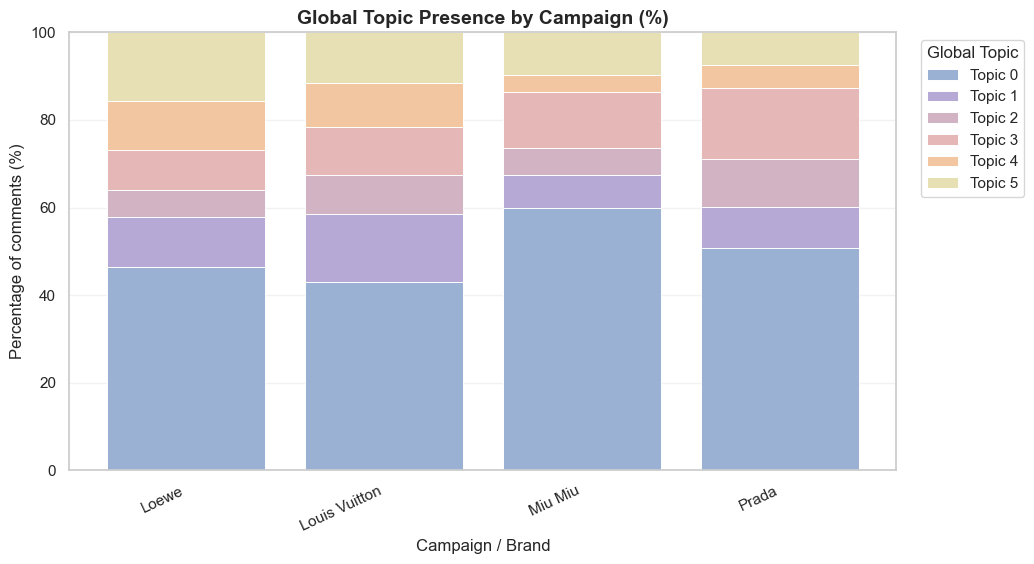

Saved: C:\Users\Pilar\TFM\figures\lda_global_topics_stacked_by_brand.png


In [25]:
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

GLOBAL_TOPIC_COLORS = {
    0: "#9BB1D4",
    1: "#B7A9D6",
    2: "#D1B3C4",
    3: "#E6B7B7",
    4: "#F2C6A0",
    5: "#E8E0B5"
}

GLOBAL_TOPIC_NAMES = {
    0: "Affective admiration & celebrity mentions",
    1: "General opinions & reactions",
    2: "Brand interaction & community talk",
    3: "Style / creativity excitement",
    4: "Product / collection & brand references",
    5: "Mixed emotions & polarized reactions"
}

GLOBAL_TOPIC_TOPWORDS = {
    0: "love, amazing, mai, lixian, secret, maimai, truths, yuta, superb, zhoudongyu, sexy, precious",
    1: "fun, good, nayeon, people, like, xian, li, look, really, think, know, yes",
    2: "approval, wow, need, help, team, hello, loewe, obsessed, thank, super, baby, wen",
    3: "excitement, perfect, gorgeous, amazing, style, prada, id, criative, insane, ruined, unique, junhui",
    4: "collection, lv, want, bag, dots, nice, prada, miu, louis, vuitton, like, bella",
    5: "sadness, beautiful, like, anger, omg, cute, looks, jun, oh, bag, better, let"
}

topics_table = pd.DataFrame({
    "Topic ID": list(GLOBAL_TOPIC_NAMES.keys()),
    "Global Topic Name": [GLOBAL_TOPIC_NAMES[i] for i in GLOBAL_TOPIC_NAMES.keys()],
    "Top words": [GLOBAL_TOPIC_TOPWORDS[i] for i in GLOBAL_TOPIC_NAMES.keys()]
})

def save_table_as_image(df, title, out_path):
    n_rows = len(df) + 1
    fig_h = 0.46 * n_rows

    fig, ax = plt.subplots(figsize=(14, fig_h))
    ax.axis("off")

    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc="left",
        colLoc="left",
        loc="center",
        bbox=[0, 0, 1, 0.88]
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9.5)

    header_bg = "#111111"
    row_bg_1 = "#F2F2F2"
    row_bg_2 = "#E7E7E7"
    edge = "#333333"

    for (row, col), cell in tbl.get_celld().items():
        cell.set_edgecolor(edge)
        cell.set_linewidth(0.8)
        cell.PAD = 0.02

        if row == 0:
            cell.set_facecolor(header_bg)
            cell.get_text().set_color("white")
            cell.get_text().set_weight("bold")
            cell.set_height(0.18)
        else:
            cell.set_facecolor(row_bg_1 if row % 2 == 1 else row_bg_2)
            cell.get_text().set_color("#1A1A1A")
            cell.set_height(0.16)

    for r in range(0, len(df) + 1):
        tbl[(r, 0)].set_width(0.08)
        tbl[(r, 1)].set_width(0.32)
        tbl[(r, 2)].set_width(0.60)

    fig.suptitle(title, fontsize=14, weight="bold", y=0.98)

    fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()
    print("Saved:", Path(out_path).resolve())

table_path = SAVE_DIR / "lda_global_topics_table.png"
save_table_as_image(topics_table, "LDA Global Topics — Summary", table_path)

BRAND_COL = "brand" if "brand" in topic_brand_global.columns else "Brand"

brands_order = ["Loewe", "Louis Vuitton", "Miu Miu", "Prada"]
topics_order = sorted(GLOBAL_TOPIC_NAMES.keys())

pivot = (
    topic_brand_global
    .pivot_table(index=BRAND_COL, columns="Global_Topic", values="Percent", aggfunc="sum")
    .reindex(index=brands_order, columns=topics_order)
    .fillna(0)
)

fig, ax = plt.subplots(figsize=(10.5, 5.8))

bottom = None
for t in topics_order:
    vals = pivot[t].values
    ax.bar(
        pivot.index,
        vals,
        bottom=bottom,
        label=f"Topic {t}",
        color=GLOBAL_TOPIC_COLORS[t],
        edgecolor="white",
        linewidth=0.7
    )
    bottom = vals if bottom is None else bottom + vals

ax.set_title("Global Topic Presence by Campaign (%)", fontsize=14, weight="bold")
ax.set_ylabel("Percentage of comments (%)")
ax.set_xlabel("Campaign / Brand")
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.25)

ax.legend(title="Global Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()

plot_path = SAVE_DIR / "lda_global_topics_stacked_by_brand.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print("Saved:", plot_path.resolve())

In [26]:
N_TOPICS_GLOBAL = 6
TOP_WORDS = 12
RANDOM_STATE = 42

TEXT_COL = "comment_clean" if "comment_clean" in df_all_nonempty.columns else "Processed_Comment"

df_all_nonempty = df_all_nonempty.copy()
df_all_nonempty[TEXT_COL] = df_all_nonempty[TEXT_COL].fillna("").astype(str)

texts = df_all_nonempty[TEXT_COL].tolist()

vectorizer_global = CountVectorizer(
    max_df=0.85,
    min_df=5,
    max_features=2000,
    token_pattern=r"(?u)\b\w\w+\b",
    stop_words="english"
)

dtm_global = vectorizer_global.fit_transform(texts)
feature_names_global = vectorizer_global.get_feature_names_out()

lda_global = LatentDirichletAllocation(
    n_components=N_TOPICS_GLOBAL,
    max_iter=12,
    learning_method="batch",
    random_state=RANDOM_STATE
)

lda_global.fit(dtm_global)

doc_topics = lda_global.transform(dtm_global)
df_all_nonempty["Global_Topic"] = doc_topics.argmax(axis=1)
df_all_nonempty["Global_Topic_Prob"] = doc_topics.max(axis=1)

# Interpreted global topic labels (final)
GLOBAL_TOPIC_LABELS = {
    0: "General positivity & admiration",
    1: "Playful interaction & community engagement",
    2: "Approval & recommendation discourse",
    3: "Aspirational style & luxury appeal",
    4: "Luxury products & collections",
    5: "Negative emotions & criticism"
}

df_all_nonempty["Global_Topic_Name"] = df_all_nonempty["Global_Topic"].map(GLOBAL_TOPIC_LABELS)

df_all_nonempty[[TEXT_COL, "Global_Topic", "Global_Topic_Name"]].head(5)


Processed_Comment  Global_Topic  \
0                                   screaming tight twat             0   
9374                                         excitement              3   
11466                                          l love ve             0   
1977   bad fact bad understatement egregious please c...             4   
1                                      jealous  sadness              1   

                                Global_Topic_Name  
0                 General positivity & admiration  
9374           Aspirational style & luxury appeal  
11466             General positivity & admiration  
1977                Luxury products & collections  
1      Playful interaction & community engagement

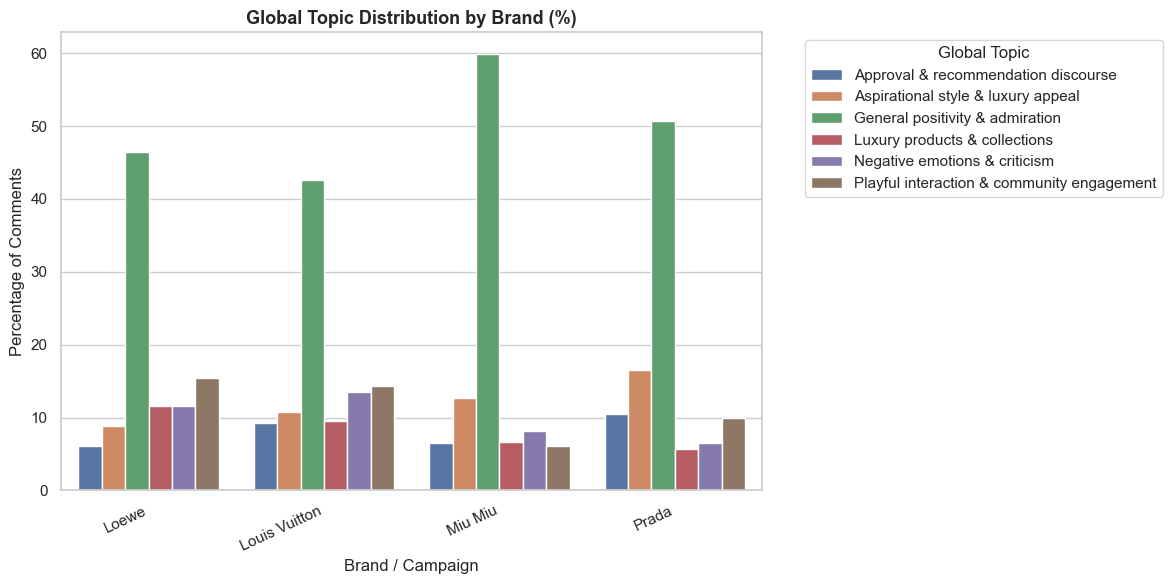

In [27]:
sns.set(style="whitegrid")

N_TOPICS_GLOBAL = 6
RANDOM_STATE = 42

BRAND_COL = "brand" if "brand" in df_all_nonempty.columns else "Brand"
TEXT_COL = "comment_clean" if "comment_clean" in df_all_nonempty.columns else "Processed_Comment"

df_all_nonempty = df_all_nonempty.copy()
df_all_nonempty[TEXT_COL] = df_all_nonempty[TEXT_COL].fillna("").astype(str)
df_all_nonempty = df_all_nonempty[df_all_nonempty[TEXT_COL].str.strip() != ""].copy()

texts = df_all_nonempty[TEXT_COL].tolist()

# Vectorization
vectorizer_global = CountVectorizer(
    max_df=0.85,
    min_df=5,
    max_features=2000,
    token_pattern=r"(?u)\b\w\w+\b",
    stop_words="english"
)
dtm_global = vectorizer_global.fit_transform(texts)

# Global LDA
lda_global = LatentDirichletAllocation(
    n_components=N_TOPICS_GLOBAL,
    max_iter=12,
    learning_method="batch",
    random_state=RANDOM_STATE
)
lda_global.fit(dtm_global)

doc_topics = lda_global.transform(dtm_global)
df_all_nonempty["Global_Topic"] = doc_topics.argmax(axis=1)
df_all_nonempty["Global_Topic_Prob"] = doc_topics.max(axis=1)


GLOBAL_TOPIC_LABELS = {
    0: "General positivity & admiration",
    1: "Playful interaction & community engagement",
    2: "Approval & recommendation discourse",
    3: "Aspirational style & luxury appeal",
    4: "Luxury products & collections",
    5: "Negative emotions & criticism"
}
df_all_nonempty["Global_Topic_Name"] = df_all_nonempty["Global_Topic"].map(GLOBAL_TOPIC_LABELS)

# Distribution by brand (%)
topic_brand = (
    df_all_nonempty
    .groupby([BRAND_COL, "Global_Topic_Name"])
    .size()
    .reset_index(name="Count")
)

topic_brand["Percent"] = (
    topic_brand["Count"]
    / topic_brand.groupby(BRAND_COL)["Count"].transform("sum")
    * 100
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=topic_brand,
    x=BRAND_COL,
    y="Percent",
    hue="Global_Topic_Name"
)

plt.title("Global Topic Distribution by Brand (%)", fontsize=13, weight="bold")
plt.ylabel("Percentage of Comments")
plt.xlabel("Brand / Campaign")
plt.legend(title="Global Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()
